
<div>
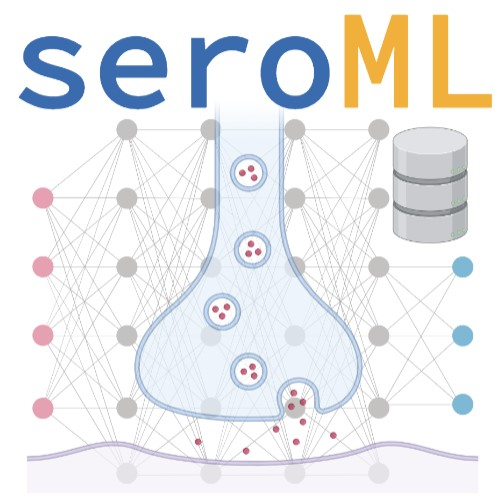
</div>

## Import Packages

In [1]:
import pandas as pd
import scipy as sp, numpy as np
from sklearn import preprocessing, model_selection
from sklearn.preprocessing import scale, StandardScaler, normalize, Normalizer
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import ShuffleSplit, LeaveOneGroupOut, LeaveOneOut, train_test_split, learning_curve, GridSearchCV, cross_val_score, cross_val_predict, RepeatedKFold
import matplotlib.pyplot as plt
import scipy.io as io
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score 
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV, MultiTaskElasticNetCV,MultiTaskElasticNet
import warnings
import ipywidgets as widgets

#error handling
warnings.filterwarnings('ignore')

## Define Functions

In [2]:
def display_scores(scores): 
    i_mean[i-1] = scores.mean()
    i_std[i-1] = scores.std()
    return i_mean, i_std

def moving_average(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

def vip(model):
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_
    p, h = w.shape
    vips = np.zeros((p,))
    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)
    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(s.T @ weight)/total_s)
    return vips

# Learning Curves
#cross validation

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


class Sample:
    instances=[]
    """Sample representing in vivo voltammograms"""
    def __init__(self,myName=0,myData=0,myTime=0,myStimType=0,myStimLength=0,myStimFreq=0,myPosition=0,myBehavior=0,myModel=0,
                myNumComp=0,myPreProcess = 0, myHyperParams = 0,mySampleName=0,myDrug=0,myAlignedData=0, myBrainRegion=0,
                my5HTbasal=0,my5HTphasic=0,myDAbasal=0,myDAphasic=0):
        self._Name = myName
        self._Data = myData
        self._Time = myTime 
        self._StimType = myStimType
        self._StimLength = myStimLength
        self._StimFreq = myStimFreq
        self._Position = myPosition
        self._Behavior = myBehavior
        self._Model = myModel
        self._NumComp = myNumComp
        self._PreProcess = myPreProcess
        self._HyperParams = myHyperParams
        self._SampleName = mySampleName
        self._Drug = myDrug
        self._AlignedData = myAlignedData
        self._BrainRegion = myBrainRegion
        self._5HT_Basal = my5HTbasal
        self._5HT_Phasic = my5HTphasic
        self._DA_Basal = myDAbasal
        self._DA_Phasic = myDAphasic
        Sample.instances.append(self)
    
    def set_StimFreq(self,stimFreq):
        self._StimFreq = stimFreq
    
    def set_StimLength(self,stimLength):
        self._StimLength = stimLength
    
    def set_Position(self,position):
        self._Position = position
    
    def set_Drug(self,drug):
        self._Drug = drug
    
    def subtractBasal(self,basal,numberPoints,phasic):
        phasic = basal-np.mean(basal[:numberPoints])
        return phasic

def myPlotFormat(myTitle,myAxesX,myAxesY):
    plt.legend()
    plt.axvspan(0, 20, color='gold', alpha=0.3);
    plt.xlabel(myAxesX,fontsize=15)
    plt.xticks(fontsize=14)
    plt.ylabel(myAxesY,fontSize=15)
    plt.yticks(fontsize=14)
    plt.title(myTitle,fontsize=18)
    fig = plt.gcf()
    fig.set_size_inches(7, 5)
    #removes duplicates from legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    return plt

## Define Widgets

In [3]:
preprocessMenu = widgets.Dropdown(
       options=['No Scale', 'Scale Features', 'Scale Samples','Normalize'],
       value='No Scale',
       description='Preprocess:')

normMenu = widgets.Dropdown(
       options=['max', 'l1', 'l2'],
       value='max',
       description='Norm:')

modelMenu = widgets.Dropdown(
       options=['PCR', 'EN', 'PLSR'],
       value='PLSR',
       description='Model:')

numCompMenu = widgets.Text(
       value='2',
       description='# Components')

cvFoldsMenu = widgets.Text(
       value='5',
       description='# CV Folds')

bkgdMenu = widgets.Dropdown(
       options=['BS', 'NBS'],
       value='NBS',
       description='Background Subtraction:')

avgMenu = widgets.Dropdown(
       options=['NA', '25A'],
       value='NA',
       description='Average Scans:')

waveformMenu = widgets.Dropdown(
       options=['Pulse', 'Tri'],
       value='Pulse',
       description='Waveform:')

fileMenu = widgets.Text(
       value=r'C:\Users\csmov\fscv_fpv_HYdata\in vivo Data FSCV_FPV_2020\in vivo Data FSCV_FPV_2020\Master_Combined\S1459_S1447_S1504_Combined.xlsx',
       description='File Path')

modelBox = widgets.VBox([modelMenu, preprocessMenu, normMenu, numCompMenu, cvFoldsMenu,waveformMenu,bkgdMenu,avgMenu, fileMenu ])


## Data Import & Preprocessing

In [27]:
modelBox

In [28]:
##TODO: replace values with .values

#insert file path below
file_location=fileMenu.value
sheetName = bkgdMenu.value+' '+avgMenu.value+' '+waveformMenu.value+'Cut'

#Hyperparameters
nComponents = int(numCompMenu.value)

#Preprocessing
preProcess = preprocessMenu.value 
myNorm = normMenu.value 

#Cross-validation
cvFolds = int(cvFoldsMenu.value)

#Model
modelChoice = modelMenu.value

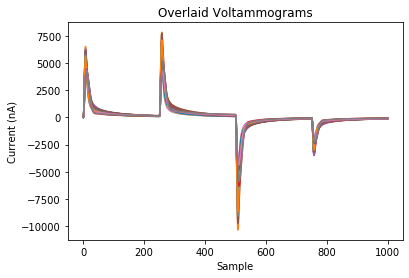

In [30]:
#import data
df_RPV = pd.read_excel(file_location, sheet_name=sheetName) #dataframe for voltammogram response
df_RPV_T = df_RPV.T #transpose to get in correct format for sklearn
df_ConcAll = pd.read_excel(file_location, sheet_name = 'Conc') #dataframe for concentrations of df_RPV responses
df_ConcDA = df_ConcAll[["DA"]] # contains only dopamine (DA) concentrations
df_ConcHT = df_ConcAll[["HT"]] # contains only serotonin (5HT) concentrations
df_Samples = pd.DataFrame((list(df_RPV.columns)),columns=['Sample']) #extracts sample code

X = df_RPV_T.to_numpy();
X_raw = df_RPV_T.to_numpy();
y = df_ConcAll.to_numpy();
y_DA = df_ConcAll['DA'].to_numpy();
y_5HT = df_ConcAll['HT'].to_numpy();

list_Samples = df_Samples.values.tolist();

plt.plot(X.T);
plt.xlabel("Sample");
plt.ylabel("Current (nA)");
plt.title("Overlaid Voltammograms");

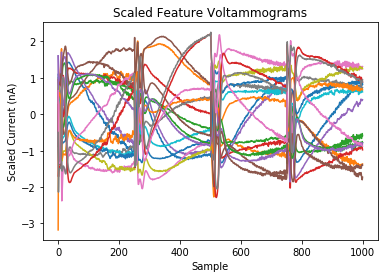

In [31]:
if preProcess == 'Scale Features':
    preProcesser = preprocessing.StandardScaler().fit(X) 
    plt.ylabel("Scaled Current (nA)");
    plt.title("Scaled Feature Voltammograms");
    
if preProcess == 'Normalize':
    preProcesser = preprocessing.Normalizer(norm=myNorm).fit(X) 
    plt.ylabel("Normalized Current (nA)");
    plt.title("Normalized Voltammograms");
    
if preProcess == 'No Scale':
    preProcesser = preprocessing.StandardScaler(with_mean=False,with_std=False).fit(X) 
    plt.ylabel("Scaled Current (nA)");
    plt.title("Non-scaled Voltammograms");
    
if preProcess == 'Scale Samples':
    preProcesser = preprocessing.StandardScaler().fit(X.T)
    plt.ylabel("Scaled Current (nA)");
    plt.title("Scaled Sample Voltammograms");
    
X = preProcesser.transform(X) 
plt.plot(X.T);
plt.xlabel("Sample");


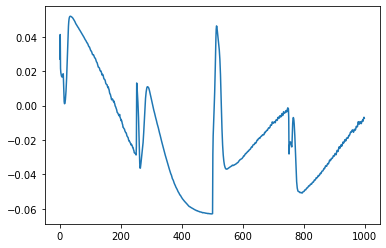

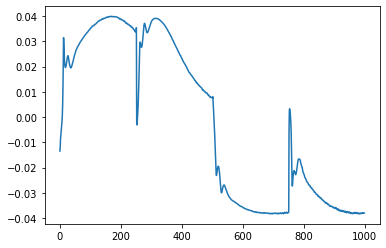

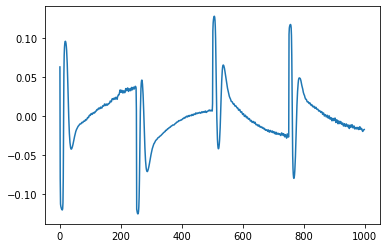

In [32]:
plsr = PLSRegression(n_components=3)
plsr.fit_transform(X_raw,y)
for i in range(3):
    plt.plot(plsr.x_loadings_[:,i])
    plt.show()

PC1 % Explained Variance: 60.72 
PC2 % Explained Variance: 39.28


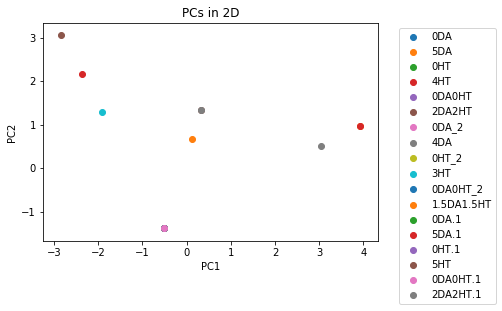

In [33]:
#PCA of Y
#ignore warnings; may need to update get_value in future.
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

pca = PCA(n_components = 2) 
principalComponents = pca.fit_transform(df_ConcAll)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df_Samples], axis = 1)

# plot and label the data in PC space
for i in range(len(df_Samples)):
    plt.scatter(finalDf.get_value(i,'principal component 1'),finalDf.get_value(i,'principal component 2'),label=finalDf.get_value(i,"Sample"))
    #plt.annotate(finalDf.get_value(i,"Sample"), (finalDf.get_value(i,'principal component 1'),finalDf.get_value(i,'principal component 2')))\

#plt.plot([-5,0,5],[0,0,0],c='k')
#plt.plot([0,0,0],[-3,0,3],c='k')
plt.title("PCs in 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1))

print("PC1 % Explained Variance:", round(pca.explained_variance_ratio_[0]*100,2), "\nPC2 % Explained Variance:", round(pca.explained_variance_ratio_[1]*100,2))

PC1 % Explained Variance: 64.66 
PC2 % Explained Variance: 23.6
Num Components for 95% Variance Explained: 4
PC1 % Explained Variance: 0.647 
PC2 % Explained Variance: 0.883


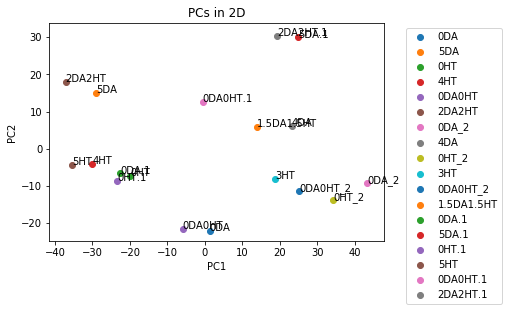

In [34]:
#PCA of X
#ignore warnings; may need to update get_value in future.
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

pca = PCA(n_components = 2) 
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df_Samples], axis = 1)

# plot and label the data in PC space
for i in range(len(df_Samples)):
    plt.scatter(finalDf.get_value(i,'principal component 1'),finalDf.get_value(i,'principal component 2'),label=finalDf.get_value(i,"Sample"))
    plt.annotate(finalDf.get_value(i,"Sample"), (finalDf.get_value(i,'principal component 1'),finalDf.get_value(i,'principal component 2')))
#plt.plot([-1,0,1],[0,0,0],c='k')
#plt.plot([0,0,0],[-1,0,1],c='k')
plt.title("PCs in 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1))
print("PC1 % Explained Variance:",round(pca.explained_variance_ratio_[0]*100,2), "\nPC2 % Explained Variance:", round(pca.explained_variance_ratio_[1]*100,2))

pca = PCA(n_components = 0.95) 
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
print("Num Components for 95% Variance Explained:", pca.n_components_)
print("PC1 % Explained Variance:", np.round(cumsum,3)[0],"\nPC2 % Explained Variance:", np.round(cumsum,3)[1])

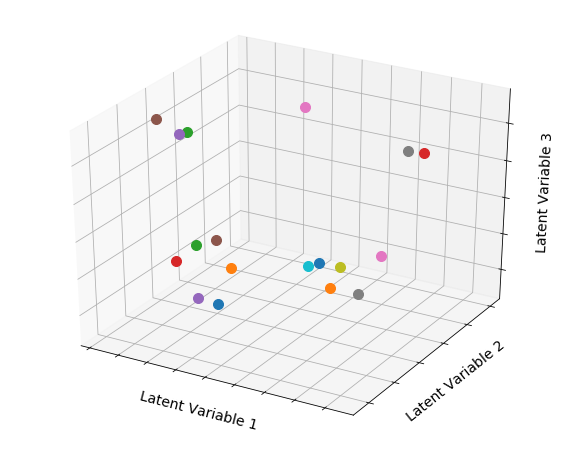

In [35]:
from mpl_toolkits.mplot3d import Axes3D

#PCA of X
#ignore warnings; may need to update get_value in future.

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

pca = PCA(n_components = 3) 

principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 
                                                                  'principal component 2',
                                                                  'principal component 3'])
finalDf = pd.concat([principalDf, df_Samples], axis = 1)

# plot and label the data in PC space
fig = plt.figure(figsize=(10,8))
ax = fig.gca(projection='3d')

for i in range(len(df_Samples)):
    ax.scatter(finalDf.get_value(i,'principal component 1'),
               finalDf.get_value(i,'principal component 2'),
               finalDf.get_value(i,'principal component 3'),s=100)

    ax.set_zlabel('Latent Variable 3',fontsize=14)
ax.set_ylabel('Latent Variable 2',fontsize=14)
ax.set_xlabel('Latent Variable 1',fontsize=14)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_zticklabels([])

plt.show()


    Number Components  Variance Explained (%), All
0                   1                        30.11
1                   2                        38.33
2                   3                        43.80
3                   4                        59.15
4                   5                        78.86
5                   6                        83.47
6                   7                        91.93
7                   8                        94.47
8                   9                        95.94
9                  10                        98.85
10                 11                        99.24
11                 12                        99.62
12                 13                        99.86
13                 14                        99.93
14                 15                       100.00
15                 16                       100.00
16                 17                       100.00
17                 18                       100.00 

    Number Components  Varian

([<matplotlib.axis.XTick at 0x19a6d6bbf88>,
 <a list of 5 Text xticklabel objects>)

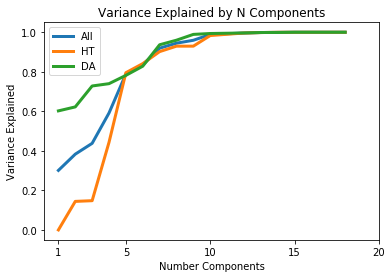

In [36]:
var_exp_DA = np.zeros(len(df_RPV_T))
var_exp_HT = np.zeros(len(df_RPV_T))
var_exp_All = np.zeros(len(df_RPV_T))
i_values = np.arange(1,len(df_RPV_T)+1)

for i in i_values:
    if modelChoice == 'PLSR':
        myModel = make_pipeline(preProcesser, PLSRegression(n_components=i,scale=False))
        myModel.fit_transform(X, y)
    if modelChoice == 'PCR':
        myModel = make_pipeline(preProcesser, PCA(n_components=i), LinearRegression()) 
        myModel.fit(X, y)
    if modelChoice == 'EN':
        myModel = make_pipeline(preProcesser, MultiTaskElasticNet()) 
        myModel.fit(X, y)
    y_pred = myModel.predict(X)
    var_exp_DA[i-1] = r2_score(y,y_pred,multioutput='raw_values')[0]
    var_exp_HT[i-1] = r2_score(y,y_pred,multioutput='raw_values')[1]
    var_exp_All[i-1] = r2_score(y,y_pred)

df_var_exp_All=pd.DataFrame({"Number Components": i_values, "Variance Explained (%), All": np.round(100*var_exp_All,2)})
df_var_exp_All.to_pickle('df_var_exp_All_'+modelChoice+'_'+preProcess+'_'+myNorm+'_'+sheetName+'_'+str(nComponents))
print(df_var_exp_All,'\n');
df_var_exp_DA=pd.DataFrame({"Number Components": i_values, "Variance Explained (%), DA": np.round(100*var_exp_DA,2)})
df_var_exp_DA.to_pickle('df_var_exp_DA_'+modelChoice+'_'+preProcess+'_'+myNorm+'_'+sheetName+'_'+str(nComponents))
print(df_var_exp_DA,'\n');
df_var_exp_HT=pd.DataFrame({"Number Components": i_values, "Variance Explained (%), HT": np.round(100*var_exp_HT,2)})
df_var_exp_HT.to_pickle('df_var_exp_HT_'+modelChoice+'_'+preProcess+'_'+myNorm+'_'+sheetName+'_'+str(nComponents))
print(df_var_exp_HT);

plt.plot(i_values,var_exp_All,label='All',linewidth=3);
plt.plot(i_values,var_exp_HT,label="HT",linewidth=3);
plt.plot(i_values,var_exp_DA,label='DA',linewidth=3);
plt.legend()
plt.title("Variance Explained by N Components");
plt.xlabel("Number Components");
plt.ylabel("Variance Explained");
plt.xticks([1,5,10,15,20])

In [37]:
#NEW CV ATTEMPT
#X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, 
#                                                   stratify=y,random_state=1)

#FOR NOW, USE LOOCV
#use 5 or 10-fold if enough data.
#use greater or LOOCV (since small data set)
#For instance, experiments by Ron Kohavi on various real-world datasets
#suggest that 10-fold cross-validation offers the best tradeoff between bias and
#variance (A Study of Cross-Validation and Bootstrap for Accuracy Estimation and Model
#Selection, Kohavi, Ron, International Joint Conference on Artificial Intelligence (IJCAI),
#14 (12): 1137-43, 1995).

#In future; go for stratified k-fold

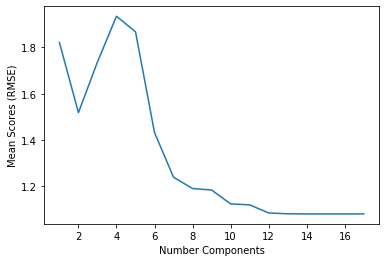

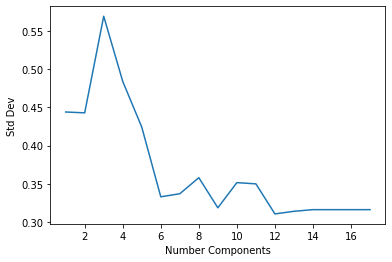

In [38]:
i_mean = np.zeros(len(df_RPV_T)-1)
i_std =np.zeros(len(df_RPV_T)-1)

for i in i_values[:-1]:
    if modelChoice == 'PLSR':
        myModel = make_pipeline(preProcesser, PLSRegression(n_components=i,scale=False))
    if modelChoice == 'PCR':
        myModel = make_pipeline(preProcesser, PCA(n_components=i), LinearRegression())
    if modelChoice == 'EN':
        myModel = make_pipeline(preProcesser, MultiTaskElasticNet()) 
    scores = cross_val_score(myModel, X, y, scoring="neg_mean_squared_error", cv=cvFolds)
    model_rmse_scores = np.sqrt(-scores)
    display_scores(model_rmse_scores)
    plt.show()

plt.plot(i_values[:-1],i_mean)
plt.xlabel("Number Components");
plt.ylabel("Mean Scores (RMSE)");
plt.show()
plt.plot(i_values[:-1],i_std)
plt.xlabel("Number Components");
plt.ylabel("Std Dev");

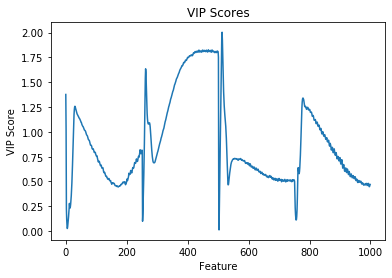

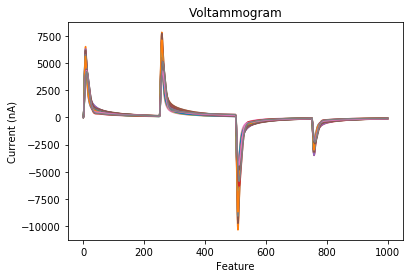

Number Features with VIP > or = 1: 332


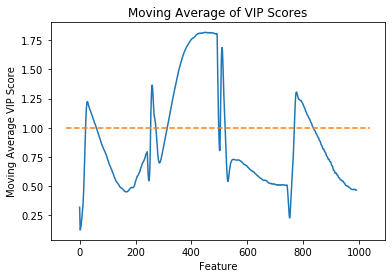

In [39]:
if modelChoice == 'PLSR':
    PLSRmodel=PLSRegression(n_components=nComponents,scale=False) #TODO
    PLSRmodel.fit_transform(X,y)
    vipPLSR = vip(PLSRmodel)
    plt.plot(vip(PLSRmodel))
    plt.xlabel("Feature")
    plt.ylabel('VIP Score')
    plt.title('VIP Scores')
    plt.show()
    plt.plot(df_RPV)
    plt.xlabel("Feature")
    plt.ylabel('Current (nA)')
    plt.title('Voltammogram')
    plt.show()

    countOver1 = 0
    for i in range(len(vipPLSR)):
        if vipPLSR[i] >= 1:
            countOver1 += 1

    print('Number Features with VIP > or = 1:',countOver1)

    plt.plot(moving_average(vipPLSR,n=10))
    plt.xlabel("Feature")
    plt.ylabel('Moving Average VIP Score')
    plt.title('Moving Average of VIP Scores')
    abline(0,1)

In [40]:
if preProcess == 'Scale Features' and modelChoice == 'PLSR':
    param_grid = [
    {'plsregression__n_components': range(len(df_RPV_T)),'standardscaler__with_mean': [True,False],
     'standardscaler__with_std': [True,False]}]

if preProcess == 'Scale Features' and modelChoice == 'PCR':
    param_grid = [
    {'pca__n_components': range(len(df_RPV_T)),'standardscaler__with_mean': [True,False],
     'standardscaler__with_std': [True,False]}]
    
if preProcess == 'No Scale' and modelChoice == 'PLSR':
    param_grid = [
    {'plsregression__n_components': range(len(df_RPV_T))}]
    
if preProcess == 'No Scale' and modelChoice == 'PCR':
    param_grid = [
    {'pca__n_components': range(len(df_RPV_T)),'linearregression__normalize':[True,False]}] 
    
if preProcess == 'Scale Samples' and modelChoice == 'PLSR':
    param_grid = [
    {'plsregression__n_components': range(len(df_RPV_T)), 'plsregression__scale':[True, False]}]

if preProcess == 'Scale Samples' and modelChoice == 'PCR':
    param_grid = [
    {'pca__n_components': range(len(df_RPV_T)), 'linearregression__normalize':[True, False]}]

if preProcess == 'Normalize' and modelChoice == 'PLSR':
    param_grid = [
    {'plsregression__n_components': range(len(df_RPV_T)),'normalizer__norm': ['l1', 'l2', 'max']}]

if preProcess == 'Normalize' and modelChoice == 'PCR':
    param_grid = [
    {'pca__n_components': range(len(df_RPV_T)),'normalizer__norm': ['l1', 'l2', 'max']}]

if modelChoice == 'PLSR':
    GSmodel = make_pipeline(preProcesser, PLSRegression(scale=False)) 
if modelChoice == 'PCR':
    GSmodel = make_pipeline(preProcesser, PCA(), LinearRegression())
if modelChoice == 'EN':
    GSmodel = make_pipeline(preProcesser, MultiTaskElasticNet())
    
grid_search = GridSearchCV(GSmodel, param_grid, cv=cvFolds,
        scoring='neg_mean_squared_error',
        return_train_score=True)

grid_search.fit(X,y);

print(grid_search.best_params_, grid_search.best_estimator_)

{'plsregression__n_components': 12, 'standardscaler__with_mean': False, 'standardscaler__with_std': False} Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=False, with_std=False)),
                ('plsregression',
                 PLSRegression(copy=True, max_iter=500, n_components=12,
                               scale=False, tol=1e-06))],
         verbose=False)


2
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
    Number Components  Variance Explained (%), All CV
0                   1                          -10.53
1                   2                           17.28
2                   3                         -174.60
3                   4                        -1087.10
4                   5                        -2340.36
5                   6                        -2071.76
6                   7                        -2349.78
7                   8                        -2358.15
8                   9                        -2358.15
9                  10                        -2358.15
10                 11                        -2358.15
11                 12                        -2358.15
12                 13                        -2358.15
13                 14                        -2358.15
14                 15                        -2358.15
15                 16                        -2358.15
16                 17              

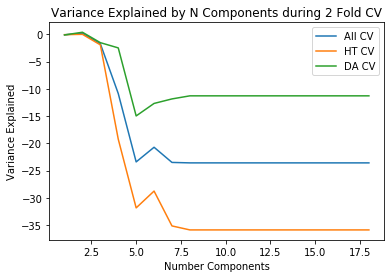

3
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
    Number Components  Variance Explained (%), All CV
0                   1                           -9.98
1                   2                           20.27
2                   3                         -411.47
3                   4                        -1514.56
4                   5                        -1985.06
5                   6                        -1518.29
6                   7                        -1387.34
7                   8                        -1286.73
8                   9                        -1333.74
9                  10                        -1611.55
10                 11                        -1604.39
11                 12                        -1604.39
12                 13                        -1604.39
13                 14                        -1604.39
14                 15                        -1604.39
15                 16                        -1604.39
16                 17              

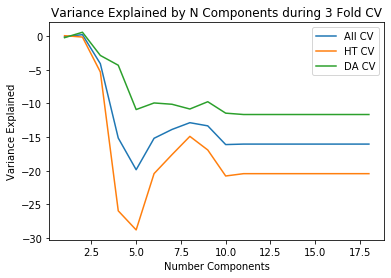

4
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
    Number Components  Variance Explained (%), All CV
0                   1                           -9.38
1                   2                           13.29
2                   3                           -8.95
3                   4                          -57.93
4                   5                          -58.21
5                   6                            0.70
6                   7                           46.94
7                   8                           50.89
8                   9                           54.45
9                  10                           59.08
10                 11                           58.32
11                 12                           59.60
12                 13                           59.89
13                 14                           59.89
14                 15                           59.89
15                 16                           59.89
16                 17              

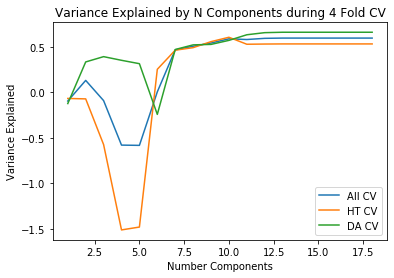

5
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
    Number Components  Variance Explained (%), All CV
0                   1                          -21.72
1                   2                           10.19
2                   3                          -18.50
3                   4                          -45.65
4                   5                          -34.64
5                   6                           23.36
6                   7                           41.94
7                   8                           45.77
8                   9                           47.63
9                  10                           52.72
10                 11                           52.69
11                 12                           56.02
12                 13                           56.31
13                 14                           56.42
14                 15                           56.42
15                 16                           56.42
16                 17              

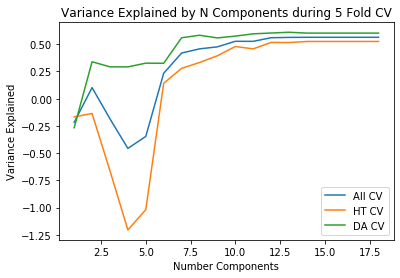

In [41]:
for cvFold in list(range(2,cvFolds+1)):
    CV_var_exp_DA = np.zeros(len(df_RPV_T))
    CV_var_exp_HT = np.zeros(len(df_RPV_T))
    CV_var_exp_All = np.zeros(len(df_RPV_T))
    print(cvFold)
    for i in (i_values):
        print(i)
        if modelChoice == 'PLSR':
            myModel = make_pipeline(preProcesser, PLSRegression(n_components=i,scale=False))
        if modelChoice == 'PCR':
            myModel = make_pipeline(preProcesser, PCA(n_components=i), LinearRegression())  
        y_train_pred = cross_val_predict(myModel, X_raw, y, cv=cvFold)
        CV_var_exp_DA[i-1] = r2_score(y_DA,y_train_pred[:,0])
        CV_var_exp_HT[i-1] = r2_score(y_5HT,y_train_pred[:,1])
        CV_var_exp_All[i-1] = r2_score(y,y_train_pred)
    df_CV_var_exp_All=pd.DataFrame({"Number Components": i_values, 
                                    "Variance Explained (%), All CV": np.round(100*CV_var_exp_All,2)})
    if cvFold == 18:   
        df_CV_var_exp_All.to_pickle('df_CV_var_exp_All_'+modelChoice+'_'+preProcess+'_'+myNorm+'_'+sheetName
                                    +'_'+str(nComponents)+'_comp'+str(cvFold)+'folds')
    print(df_CV_var_exp_All,'\n');
    df_CV_var_exp_DA=pd.DataFrame({"Number Components": i_values, "Variance Explained (%), DA CV": np.round(100*CV_var_exp_DA,2)})
    if cvFold == 18:
        df_CV_var_exp_DA.to_pickle('df_CV_var_exp_DA_'+modelChoice+'_'+preProcess+'_'+myNorm+'_'+sheetName
                                    +'_'+str(nComponents)+'_comp'+str(cvFold)+'folds')
    print(df_CV_var_exp_DA,'\n');
    df_CV_var_exp_HT=pd.DataFrame({"Number Components": i_values, "Variance Explained (%), HT CV": np.round(100*CV_var_exp_HT,2)})
    if cvFold == 18:
        df_CV_var_exp_HT.to_pickle('df_CV_var_exp_HT_'+modelChoice+'_'+preProcess+'_'+myNorm+'_'+sheetName
                                    +'_'+str(nComponents)+'_comp'+str(cvFold)+'folds')
    print(df_CV_var_exp_HT);
    plt.plot(i_values,CV_var_exp_All,label='All CV');
    plt.plot(i_values,CV_var_exp_HT,label="HT CV");
    plt.plot(i_values,CV_var_exp_DA,label='DA CV');
    plt.legend()
    plt.title("Variance Explained by N Components during "+str(cvFold)+" Fold CV");
    plt.xlabel("Number Components");
    plt.ylabel("Variance Explained");
    plt.show()

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
[-0.21715055  0.1019059  -0.18500472 -0.45650178 -0.34635981  0.23362218
  0.41938331  0.45771679  0.47633009  0.52722979  0.52687408  0.56019134
  0.56314583  0.56417039  0.56417039  0.56417039  0.56417039  0.56417039]
[0.30112658 0.38331713 0.4380072  0.59152137 0.78856634 0.83474337
 0.91934162 0.94469125 0.95937829 0.98846554 0.99237913 0.99618929
 0.99856364 0.99932944 0.99995191 0.9999997  1.         1.        ]


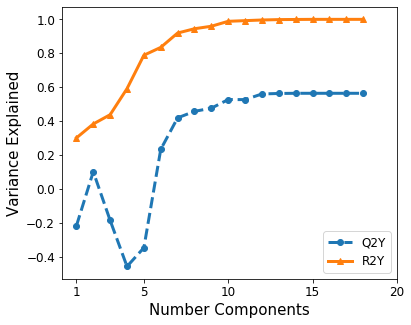

In [42]:
plt.plot(i_values,CV_var_exp_All,label='Q2Y',linewidth=3,linestyle='dashed',marker='o');
print(i_values)
print(CV_var_exp_All)
print(var_exp_All)
plt.plot(i_values,var_exp_All,label='R2Y',linewidth=3,marker='^');
plt.legend(loc=4,fontsize='large')
plt.xticks([1,5,10,15,20],fontsize=12)
plt.xlabel("Number Components",fontsize=15);
plt.ylabel("Variance Explained",fontsize=15);
plt.yticks(fontsize=12)
fig = plt.gcf()
fig.set_size_inches(6, 5)
plt.show()

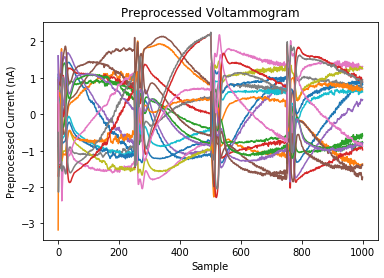

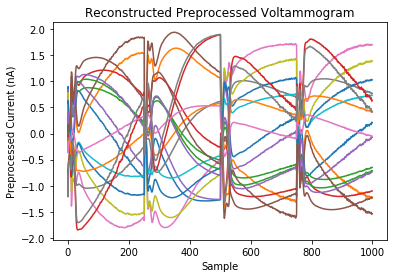

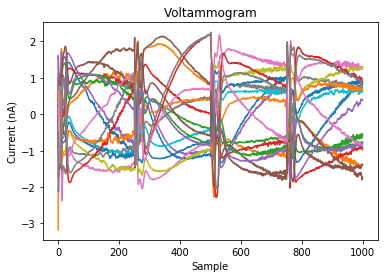

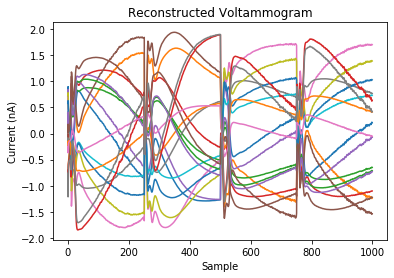

Reconstruction Error (%): 12.13


In [43]:
#R2X
if modelChoice == 'PCR':
    pca = PCA(n_components=nComponents);
    X_reduced = pca.fit_transform(X);
    X_recovered = pca.inverse_transform(X_reduced);
    
if modelChoice == 'PLSR':
    plsr = PLSRegression(n_components=nComponents,scale=False);
    X_reduced = plsr.fit_transform(X,y);
    X_recovered = plsr.inverse_transform(plsr.x_scores_);
    
plt.plot(X.T);
plt.xlabel('Sample')
plt.ylabel('Preprocessed Current (nA)')
plt.title('Preprocessed Voltammogram')
plt.show();
plt.plot((X_recovered).T);
plt.xlabel('Sample')
plt.ylabel('Preprocessed Current (nA)')
plt.title('Reconstructed Preprocessed Voltammogram')
plt.show()

if preProcess != 'Normalize':
    plt.plot((preProcesser.inverse_transform(X)).T);
    plt.xlabel('Sample')
    plt.ylabel('Current (nA)')
    plt.title('Voltammogram')
    plt.show();
    plt.plot((preProcesser.inverse_transform(X_recovered)).T);
    plt.xlabel('Sample')
    plt.ylabel('Current (nA)')
    plt.title('Reconstructed Voltammogram')
    plt.show()

print("Reconstruction Error (%):", 100*round(1-r2_score(X,X_recovered),4))

    Predicted DA  Actual DA  Predicted 5HT  Actual 5HT
0          -0.71        0.0           0.77         0.0
1           2.58        5.0           1.80         0.0
2           0.36        0.0           1.34         0.0
3           0.70        0.0           1.64         4.0
4          -0.70        0.0           0.94         0.0
5           2.73        2.0           2.00         2.0
6           0.37        0.0          -0.11         0.0
7           1.96        4.0           0.54         0.0
8          -0.02        0.0           0.06         0.0
9           0.49        0.0           0.49         3.0
10          0.16        0.0           0.29         0.0
11          1.90        1.5           0.75         1.5
12          0.11        0.0           1.37         0.0
13          3.77        5.0           0.69         0.0
14         -0.05        0.0           1.38         0.0
15          0.25        0.0           1.69         5.0
16          1.83        0.0           1.04         0.0
17        

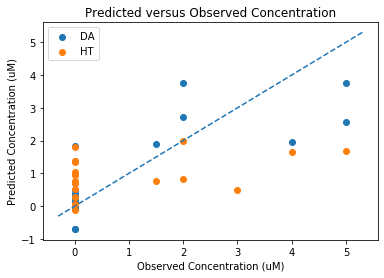

In [44]:
if modelChoice == 'PLSR':
    myModel = make_pipeline(preProcesser, PLSRegression(n_components=nComponents,scale=False))
    myModel.fit_transform(X, y)
if modelChoice == 'PCR':
    myModel = make_pipeline(preProcesser, PCA(n_components=nComponents), LinearRegression()) 
    myModel.fit(X, y)
if modelChoice == 'EN':
    myModel = make_pipeline(preProcesser, MultiTaskElasticNet()) 
    myModel.fit(X, y)

#R2Y
if modelChoice =='PCR':
    myModel.fit(X_raw,y)
if modelChoice =='PLSR':
    myModel.fit_transform(X_raw,y)
if modelChoice =='EN':
    myModel.fit(X_raw,y)
y_pred = myModel.predict(X_raw)
df_PredConc=pd.DataFrame({"Predicted DA": np.round(y_pred[:,0],2),'Actual DA':np.round(y[:,0],2),
                     "Predicted 5HT": np.round(y_pred[:,1],2),'Actual 5HT':np.round(y[:,1],2)})
print(df_PredConc)

r2_score_DA = r2_score(y_DA,y_pred[:,0],multioutput='raw_values')
r2_score_5HT = r2_score(y_5HT,y_pred[:,1],multioutput='raw_values')
print('R2Y DA:',(100*np.round(r2_score_DA,4)))
print('R2Y 5HT:', (100*np.round(r2_score_5HT,4)))
print('R2Y All:',100*np.round(r2_score(y,y_pred),4))

plt.scatter(df_ConcAll["DA"],y_pred[:,0], label="DA");
plt.scatter(df_ConcAll["HT"],y_pred[:,1], label="HT");
plt.xlabel('Observed Concentration (uM)')
plt.ylabel('Predicted Concentration (uM)')
plt.title("Predicted versus Observed Concentration")
abline(1,0)
plt.plot();
plt.legend();

#debug code
R2Y_DA = 1-(np.sum((y_pred[:,0]-y_DA)**2))/(np.sum((y_DA-np.mean(y_DA))**2))
R2Y_5HT = 1-(np.sum((y_pred[:,1]-y_5HT)**2))/(np.sum((y_5HT-np.mean(y_5HT))**2))
assert R2Y_DA == r2_score_DA
assert R2Y_5HT == r2_score_5HT

    Number Components  Variance Explained (%), All CV
0                   1                          -21.72
1                   2                           10.19
2                   3                          -18.50
3                   4                          -45.65
4                   5                          -34.64
5                   6                           23.36
6                   7                           41.94
7                   8                           45.77
8                   9                           47.63
9                  10                           52.72
10                 11                           52.69
11                 12                            0.00
12                 13                            0.00
13                 14                            0.00
14                 15                            0.00
15                 16                            0.00
16                 17                            0.00
17                 18       

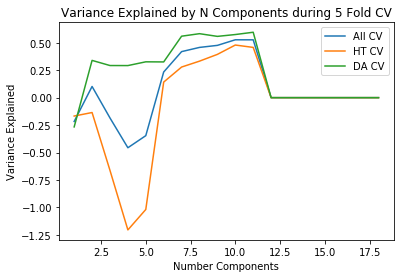

In [45]:
CV_var_exp_DA = np.zeros(len(df_RPV_T))
CV_var_exp_HT = np.zeros(len(df_RPV_T))
CV_var_exp_All = np.zeros(len(df_RPV_T))

for i in [1,2,3,4,5,6,7,8,9,10,11]:
    if modelChoice == 'PLSR':
        myModel = make_pipeline(preProcesser, PLSRegression(n_components=i,scale=False))
    if modelChoice == 'PCR':
        myModel = make_pipeline(preProcesser, PCA(n_components=i), LinearRegression())  
    #cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    y_train_pred = cross_val_predict(myModel, X_raw, y,cv=5)
    CV_var_exp_DA[i-1] = r2_score(y_DA,y_train_pred[:,0])
    CV_var_exp_HT[i-1] = r2_score(y_5HT,y_train_pred[:,1])
    CV_var_exp_All[i-1] = r2_score(y,y_train_pred)
    
df_CV_var_exp_All=pd.DataFrame({"Number Components": i_values, 
                                "Variance Explained (%), All CV": np.round(100*CV_var_exp_All,2)})
print(df_CV_var_exp_All,'\n');
df_CV_var_exp_DA=pd.DataFrame({"Number Components": i_values, 
                               "Variance Explained (%), DA CV": np.round(100*CV_var_exp_DA,2)})
print(df_CV_var_exp_DA,'\n');
df_CV_var_exp_HT=pd.DataFrame({"Number Components": i_values, 
                               "Variance Explained (%), HT CV": np.round(100*CV_var_exp_HT,2)})
print(df_CV_var_exp_HT);
plt.plot(i_values,CV_var_exp_All,label='All CV');
plt.plot(i_values,CV_var_exp_HT,label="HT CV");
plt.plot(i_values,CV_var_exp_DA,label='DA CV');
plt.legend()
plt.title("Variance Explained by N Components during "+str(cvFold)+" Fold CV");
plt.xlabel("Number Components");
plt.ylabel("Variance Explained");
plt.show()

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

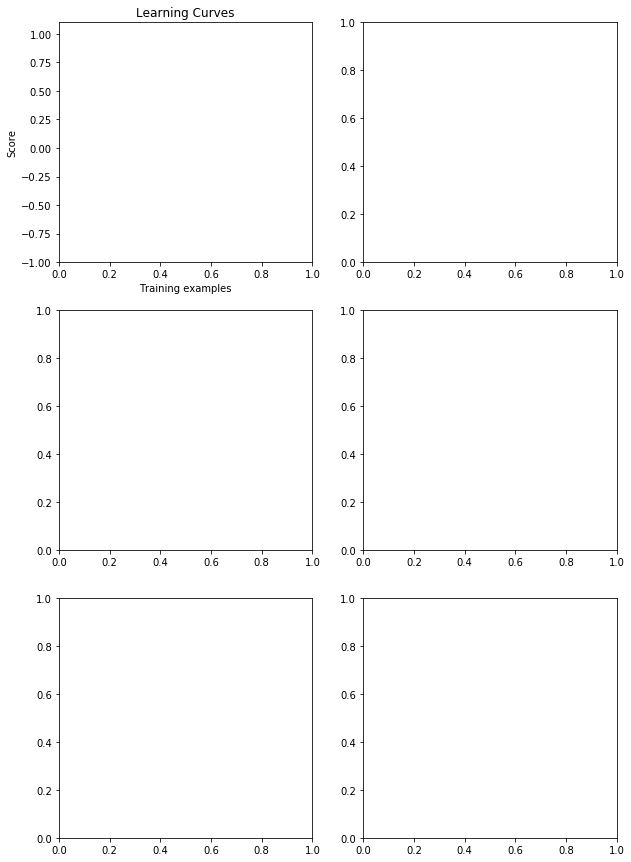

In [22]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "Learning Curves"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=18, test_size=0.1, random_state=0)

estimator = myModel
plot_learning_curve(estimator, title, X_raw, y, axes=axes[:, 0], ylim=(-1, 1.1),
                    cv=cv, n_jobs=4)

plt.show()

[[       nan        nan        nan        nan        nan]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.        ]
 [0.99809309 0.99929256 0.99628363 0.99937697 0.99760738]]
[[          nan           nan           nan           nan           nan]
 [   0.42598128 -103.76857839  -79.55907891   -0.89498441  -32.78017182]
 [   0.51841363    0.25005871    0.56904962  -14.53444127  -93.75125915]
 [   0.64101758   -0.26786308    0.21898071  -10.25745137  -74.07071443]
 [   0.72928479    0.46297681    0.38411288   -0.41161594   -1.12098679]]


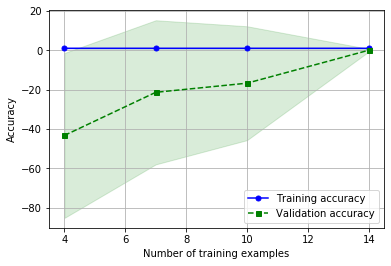

In [46]:
train_sizes, train_scores, test_scores = learning_curve(estimator=myModel, 
                                                        X=X_raw, y=y, scoring='r2',
                                                        cv=5, n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
print(train_scores)
print(test_scores)

plt.plot(train_sizes, train_mean,color='blue', marker='o',markersize=5, label='Training accuracy')
plt.fill_between(train_sizes,train_mean + train_std,train_mean - train_std,alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,color='green', linestyle='--',marker='s', markersize=5,label='Validation accuracy')
plt.fill_between(train_sizes,test_mean + test_std,test_mean - test_std,alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
#plt.ylim([0.0, 1.03])
plt.show()

In [ ]:
from sklearn.model_selection import validation_curve
param_range = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
train_scores, test_scores = validation_curve(estimator=myModel,X=X_raw,y=y,scoring='r2',
                                             param_name='plsregression__n_components',param_range=param_range,cv=2)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

print(test_scores)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean,color='green', linestyle='--',marker='s', markersize=5,label='Validation accuracy')
plt.fill_between(param_range,test_mean + test_std,test_mean - test_std,alpha=0.15, color='green')

plt.grid()
plt.legend(loc='lower right')
plt.xlabel('Num Comp')
plt.ylabel('Accuracy')
#plt.ylim([0, 1.0])
plt.show()

# In Vivo Analysis

In [47]:
time_array = np.arange(0,492)
time_array = (time_array - 200)*1*400/1000
time_array_500 = (np.arange(0,501)-200)*400/1000

stimulationFiles = ['\\25800_P1','\\27800_P1','\\33850_P1',
                    '\\9300_P1_2','\\11250_P1_2','\\13180_P1_2','\\16280_P1_2','\\18000_P1_2','\\22080_P1_2','\\23800_P1_2','\\26400_P1_2','\\31900_P1_2',
                    '\\20100_postinj','\\22050_postinj','\\23950_postinj','\\28200_postinj','\\31550_postinj','\\33350_postinj','\\34900_postinj']
#stimulationFiles= ['\\14950_postESC', '\\17030_postESC']

nameFiles = []
for i in stimulationFiles:
    nameFiles.append('Obj'+i[1:])

objs = list()

compRange=[2,3]
for x in compRange:
    print('Training ' + str(x) + ' component model...')
    j=0
    if modelChoice == 'PLSR':
        myModel = make_pipeline(preProcesser, PLSRegression(n_components=x,scale=False))
        myModel.fit_transform(X_raw,y)
    if modelChoice == 'PCR':
        myModel = make_pipeline(preProcesser, PCA(n_components=x), LinearRegression())          
        myModel.fit(X_raw,y)
    
    for i in stimulationFiles:
        #iv_file_location=r'C:\Users\csmov\fscv_fpv_HYdata\in vivo Data FSCV_FPV_2020\in vivo Data FSCV_FPV_2020\20190112'
        iv_file_location=r'C:\Users\csmov\fscv_fpv_HYdata\in vivo Data FSCV_FPV_2020\in vivo Data FSCV_FPV_2020\20190113'
        if sheetName[-6:]=='TriCut':
            iv_file_location=iv_file_location+i+'_TriCut'+'.xlsx'
        else:
            iv_file_location=iv_file_location+i+'.xlsx'
        sheetNameIV = sheetName
        df_RPV_iv = pd.read_excel(iv_file_location, sheet_name=sheetNameIV,header=None) #dataframe for voltammogram response
        df_RPV_iv_T = df_RPV_iv.T #transpose to get in correct format for sklearn
        X_iv = df_RPV_iv_T.to_numpy()
        results = myModel.predict(X_iv)
        #print(pd.DataFrame({"Sample": df_RPV_iv_T.index,"Predicted DA (uM)": np.round(results[:,0],4),"Predicted 5HT (uM)": np.round(results[:,1],4)}))
        df_results=pd.DataFrame({"Predicted DA (uM)": np.round(results[:,0],4),"Predicted 5HT (uM)": np.round(results[:,1],4)})
        df_results.name = str(i[1:])+'_'+str(x)+'comp'
        predDA = df_results['Predicted DA (uM)'].to_numpy()
        predHT = df_results['Predicted 5HT (uM)'].to_numpy()
        
        numComps=x
        mySampleName = i
        
        objs.append(Sample(myName=i+'_' + preProcess + ' ' + modelChoice + ' ' + str(x) + ' Components ',
                           myData=df_results,myTime=i,myModel=modelChoice,myNumComp=x,myPreProcess=preProcess,
                           mySampleName=nameFiles[j]))
        j+=1
        
print("Training Complete!")

Training 2 component model...
Training 3 component model...
Training Complete!


In [48]:
for i in objs:   
    if i._Time in ['\\33850_P1','\\11250_P1_2']:
        i._StimFreq=40
        i._StimLength=20
    if i._Time in ['\\25800_P1','\\27800_P1','\\9300_P1_2','\\13180_P1_2','\\16280_P1_2', '\\18000_P1_2','\\22080_P1_2','\\23800_P1_2','\\26400_P1_2','\\31900_P1_2','\\20100_postinj','\\22050_postinj','\\23950_postinj','\\28200_postinj','\\31550_postinj','\\33350_postinj','\\34900_postinj']:
        i._StimFreq=30
        i._StimLength=20
        
    if i._Time in ['\\25800_P1','\\27800_P1','\\33850_P1']:
        i._Position=11803
    if i._Time in ['\\9300_P1_2','\\11250_P1_2', '\\13180_P1_2','\\16280_P1_2', '\\18000_P1_2']:
        i._Position=11950
    if i._Time in ['\\22080_P1_2','\\23800_P1_2', '\\26400_P1_2','\\31900_P1_2','\\20100_postinj','\\22050_postinj','\\23950_postinj','\\28200_postinj']:
        i._Position=12150
    if i._Time in ['\\33350_postinj','\\31550_postinj','\\34900_postinj']:
        i._Position=12350
        
    if i._Time in ['\\20100_postinj','\\22050_postinj','\\23950_postinj','\\28200_postinj','\\31550_postinj','\\33350_postinj','\\34900_postinj']:
        i._Drug='post-SSRI'
    if i._Time not in ['\\20100_postinj','\\22050_postinj','\\23950_postinj','\\28200_postinj','\\31550_postinj','\\33350_postinj','\\34900_postinj']:
        i._Drug='pre-SSRI'
        
    i._DA_Basal = i._Data['Predicted DA (uM)'].to_numpy()
    i._DA_Phasic = i._DA_Basal-np.round(np.mean((i._Data['Predicted DA (uM)'].iloc[:101]).to_numpy()),3)
    i._5HT_Basal = i._Data['Predicted 5HT (uM)'].to_numpy()
    i._5HT_Phasic = i._5HT_Basal-np.round(np.mean((i._Data['Predicted 5HT (uM)'].iloc[:101]).to_numpy()),3)
    if i._Position == 12350:
        i._BrainRegion = 'Ventral'
    if i._Position != 12350:
        i._BrainRegion = 'Dorsal'
    if i._Time == '\\23950_postinj':
        i._StimType = 'None'
    else: 
        i._StimType='Pulse'

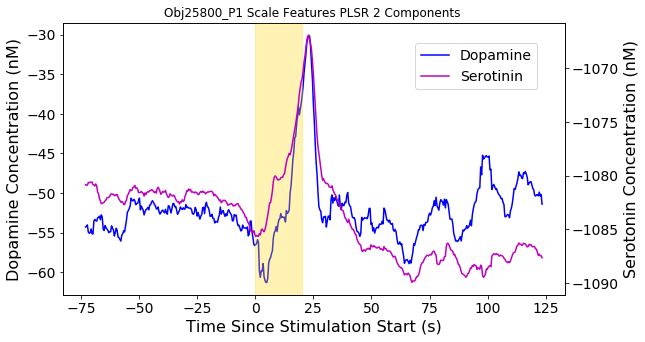

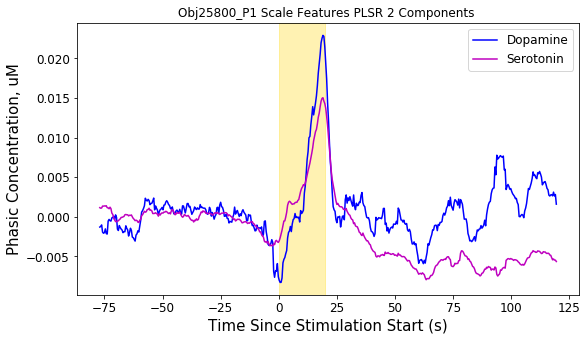

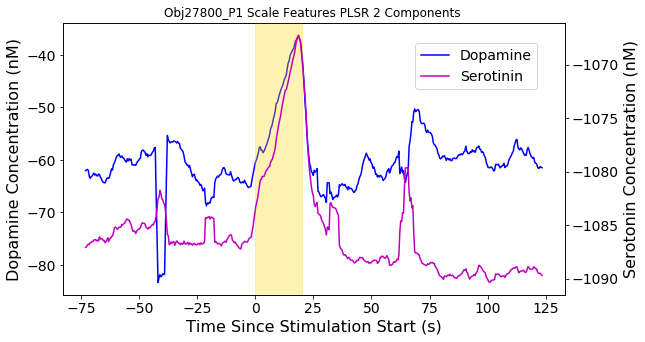

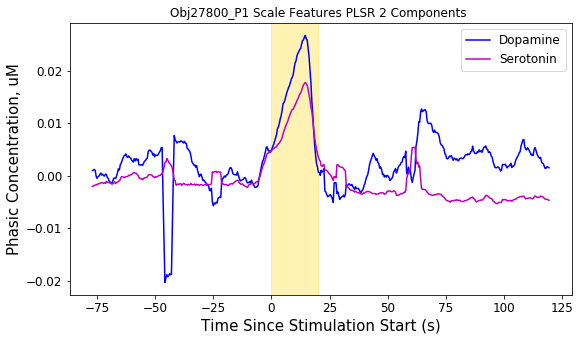

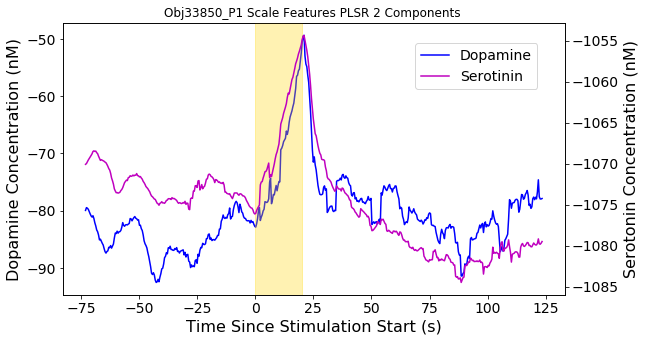

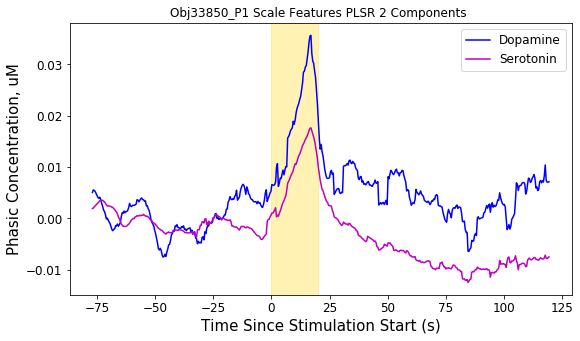

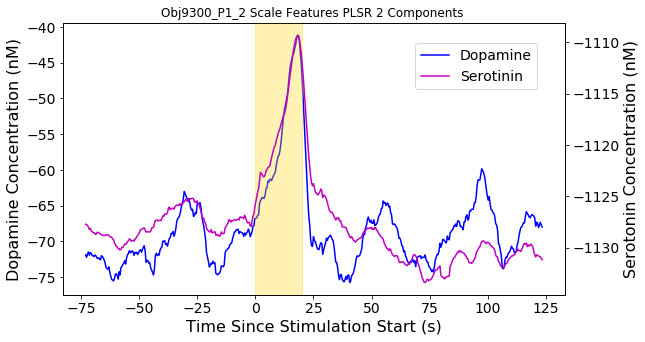

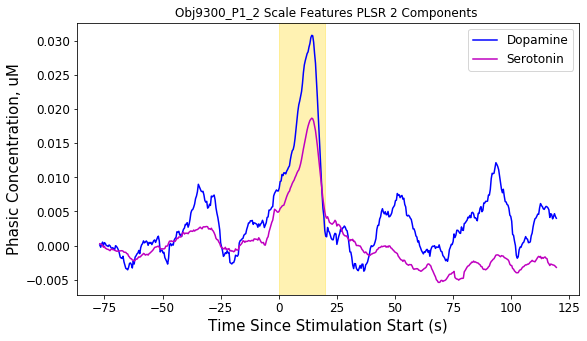

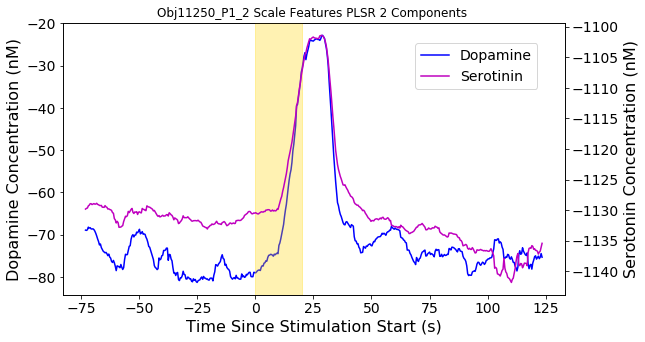

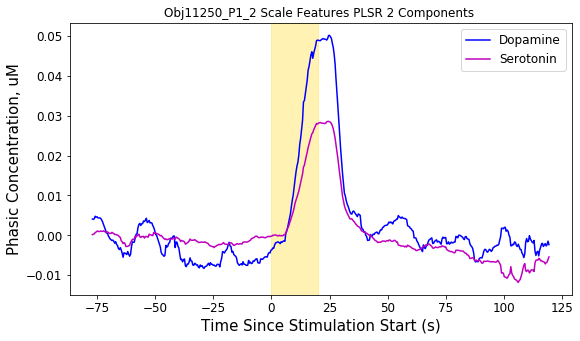

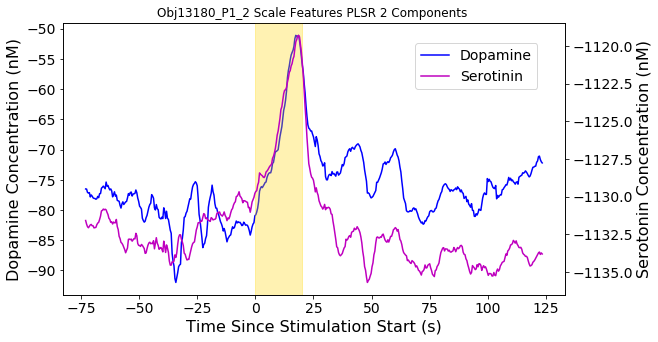

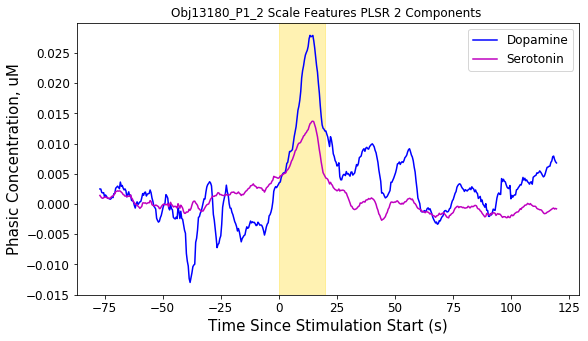

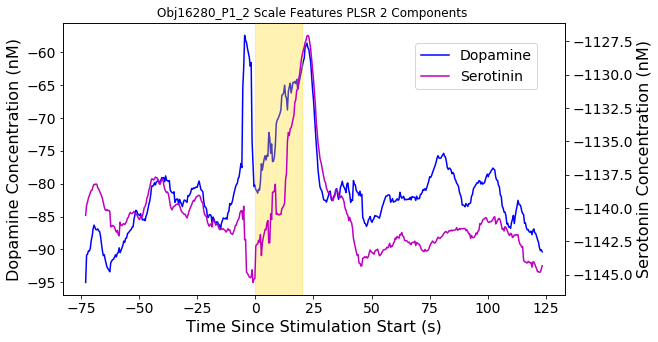

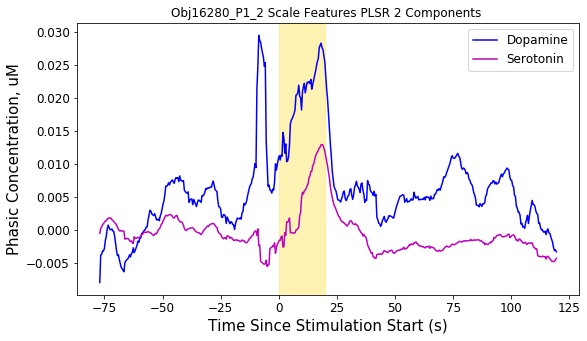

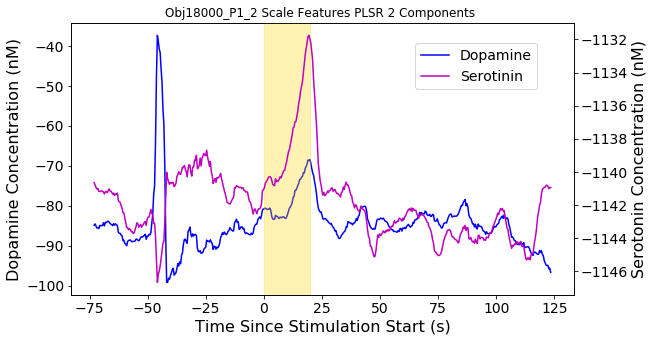

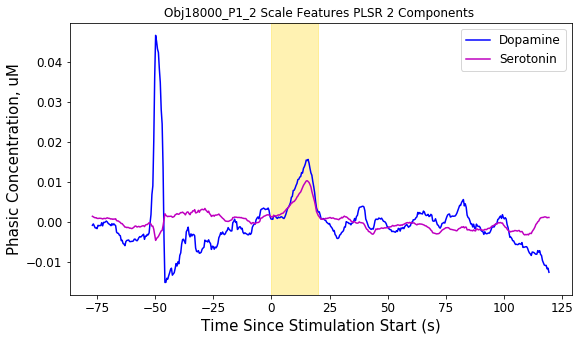

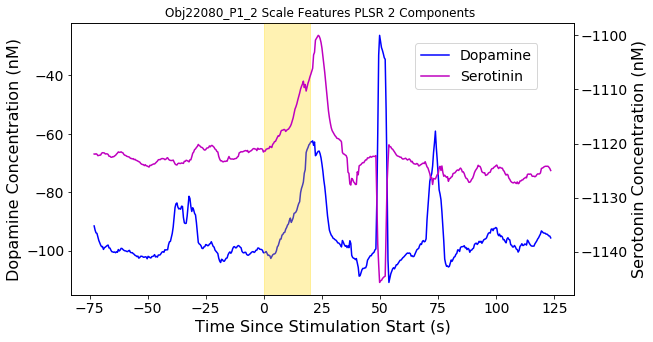

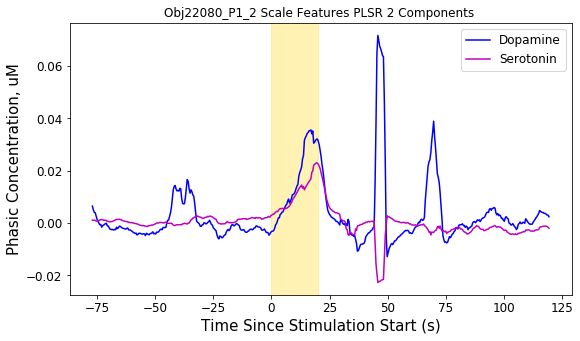

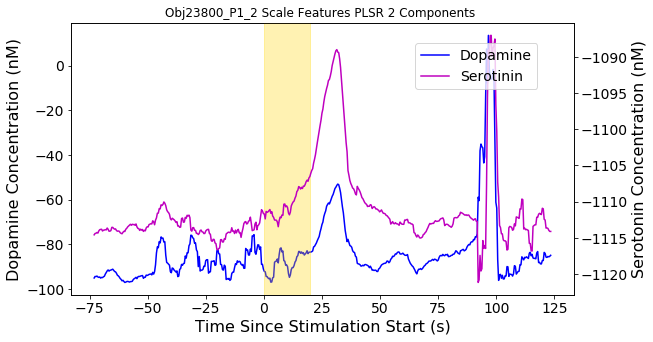

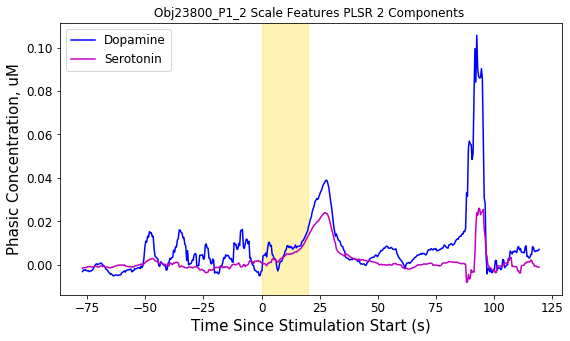

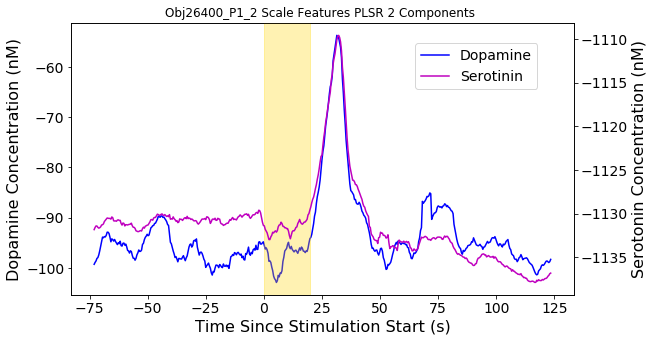

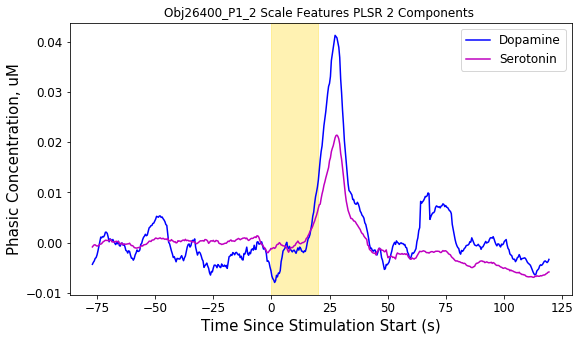

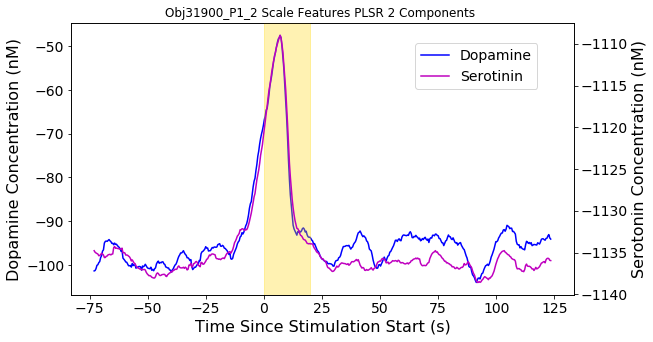

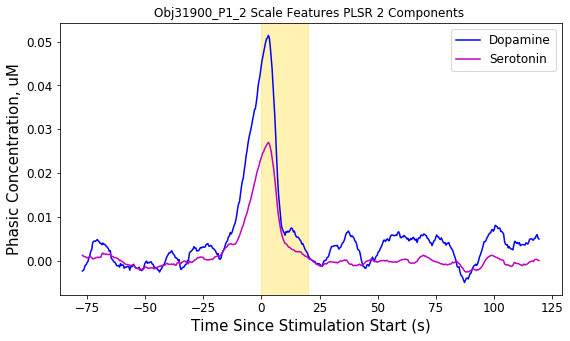

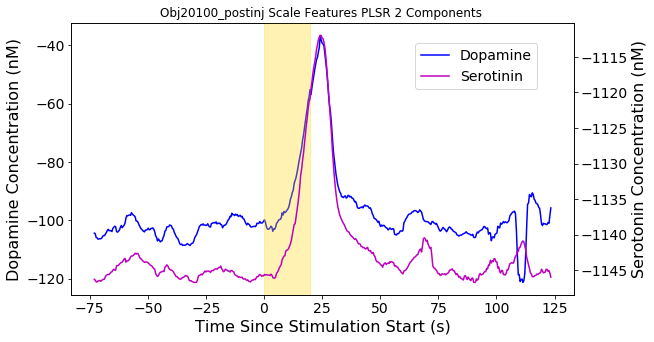

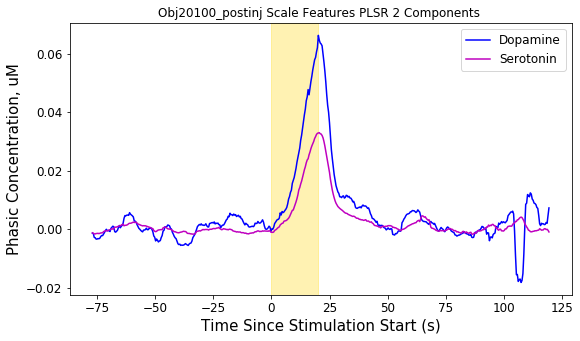

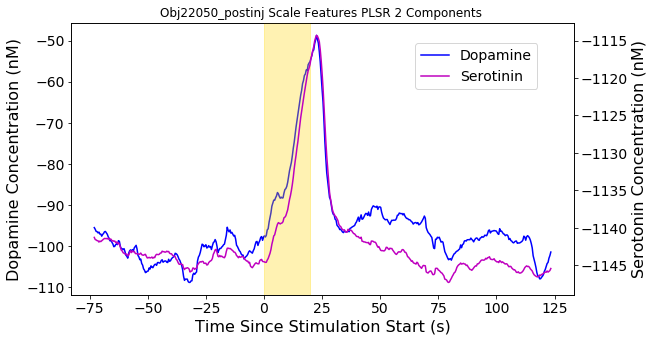

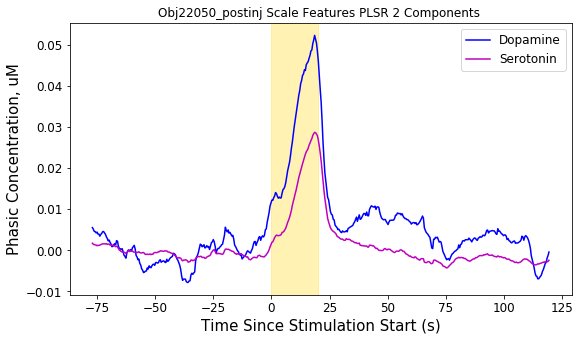

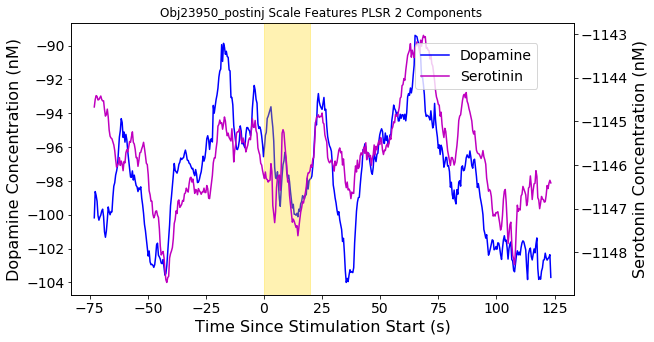

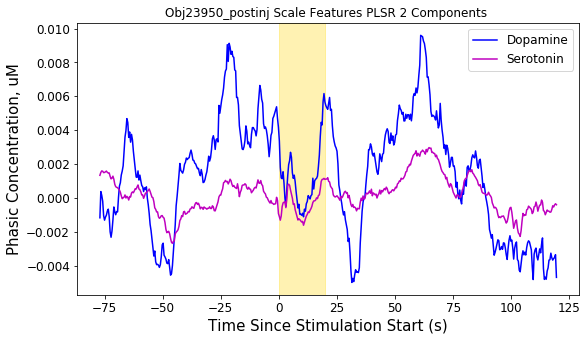

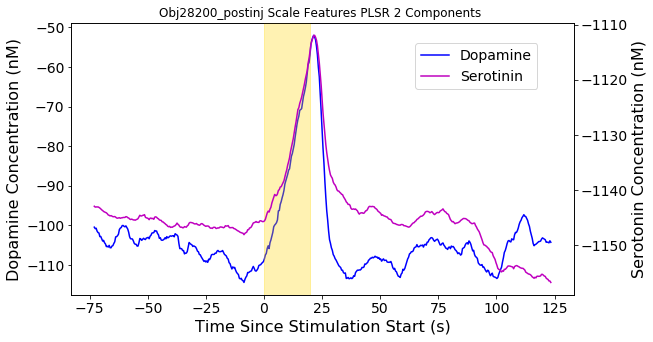

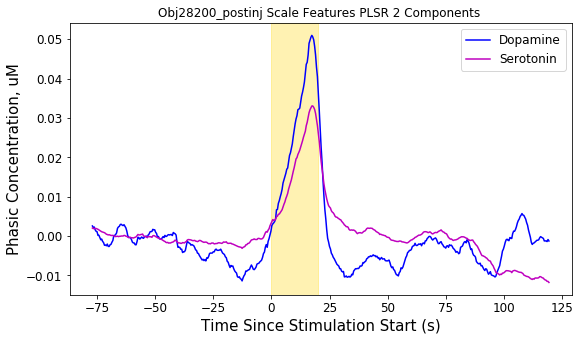

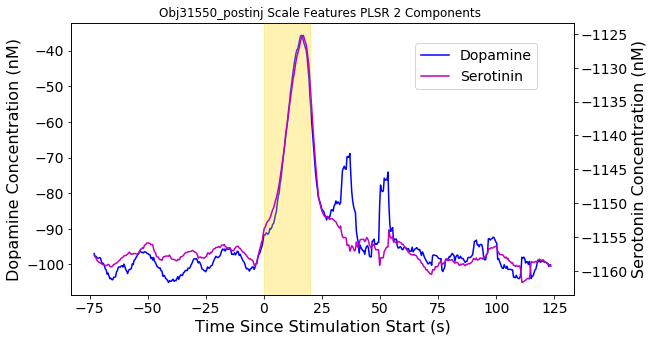

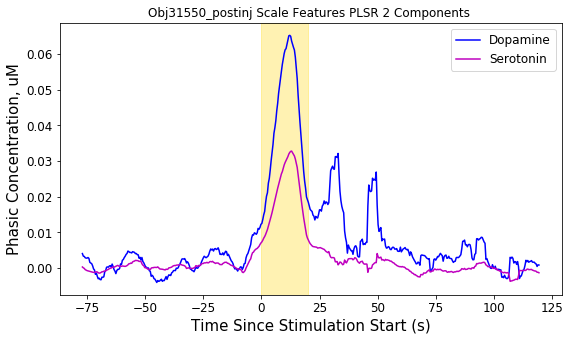

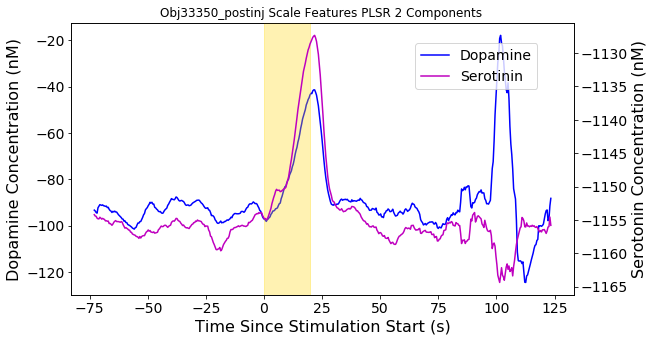

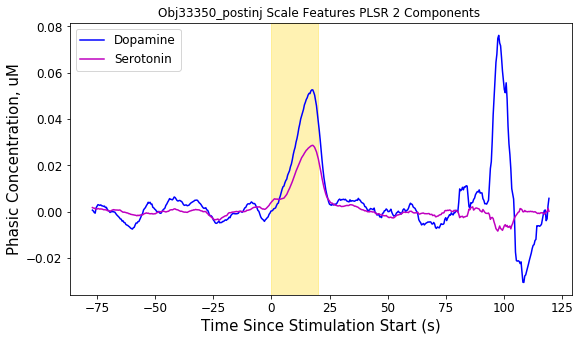

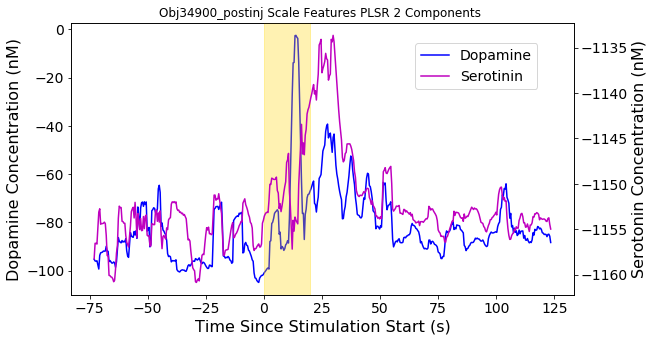

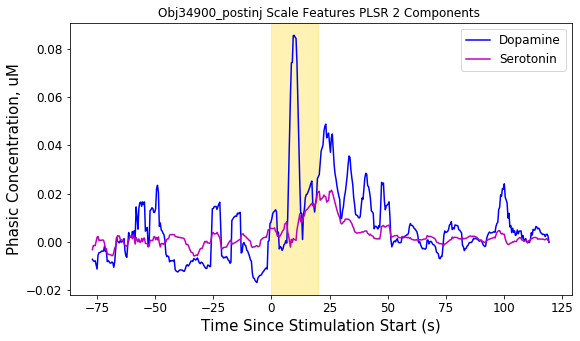

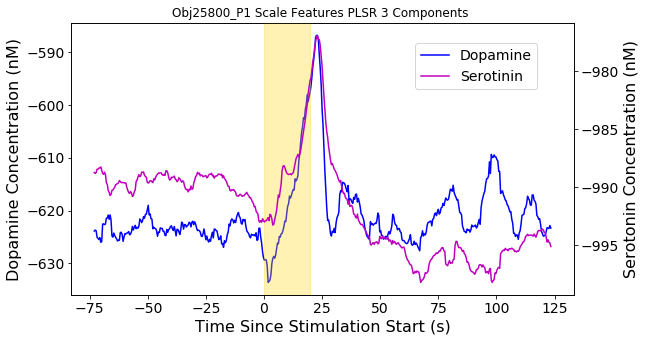

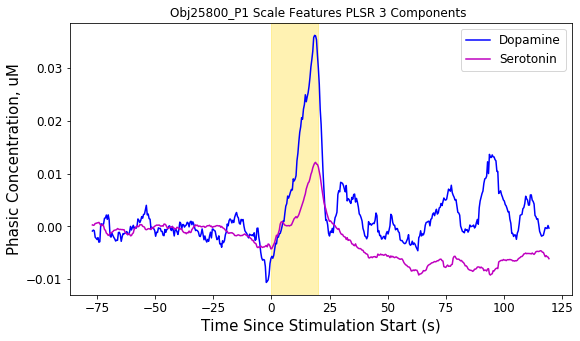

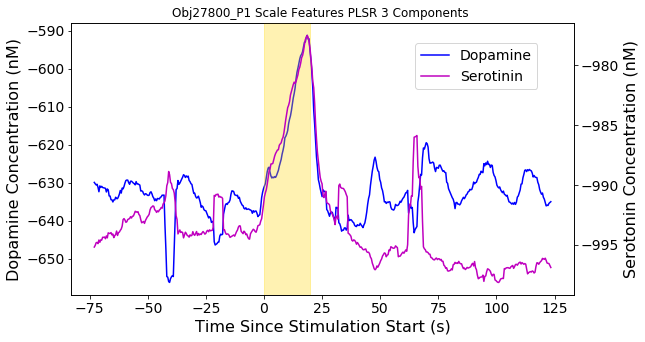

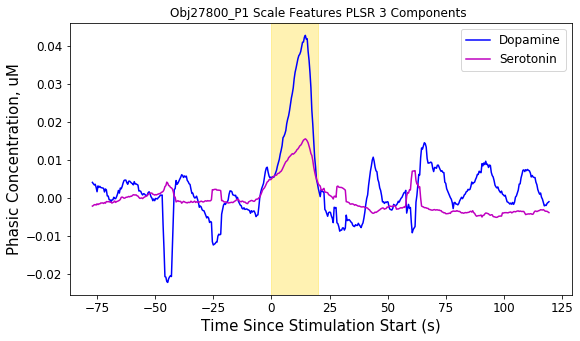

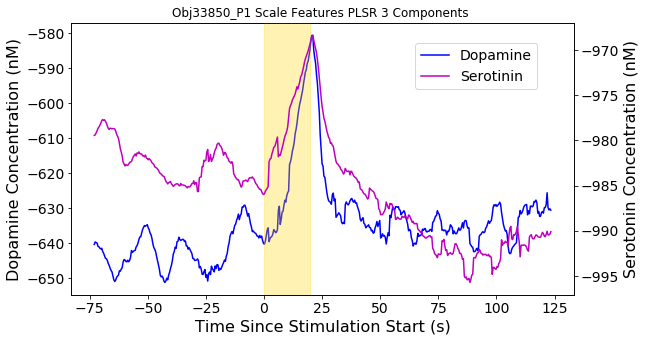

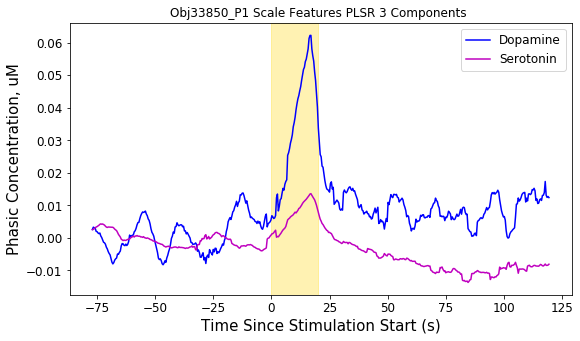

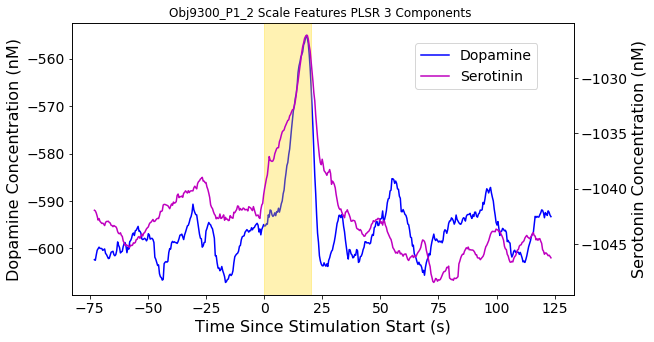

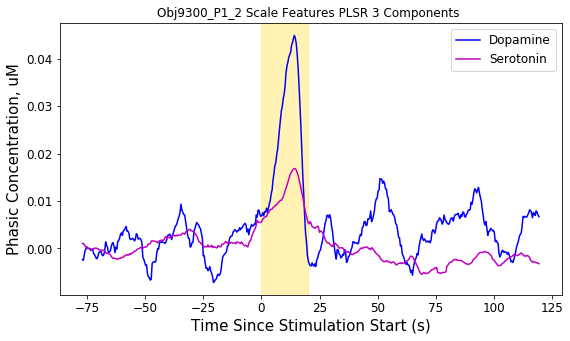

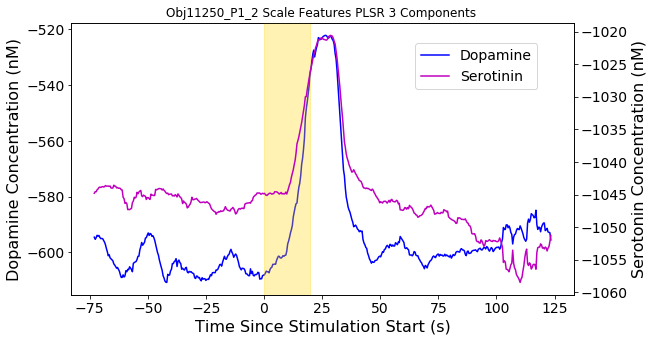

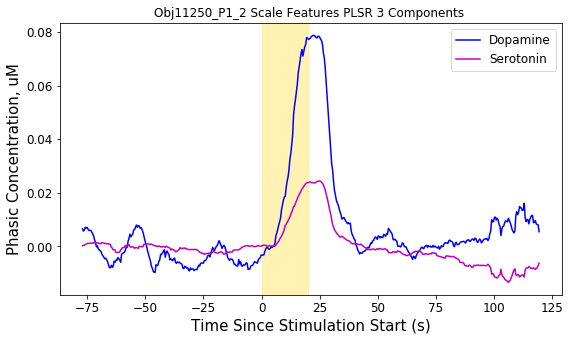

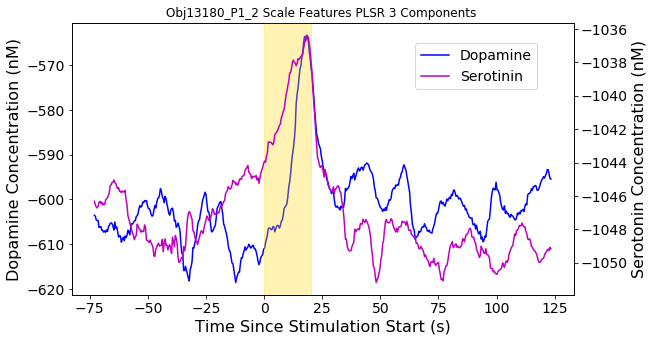

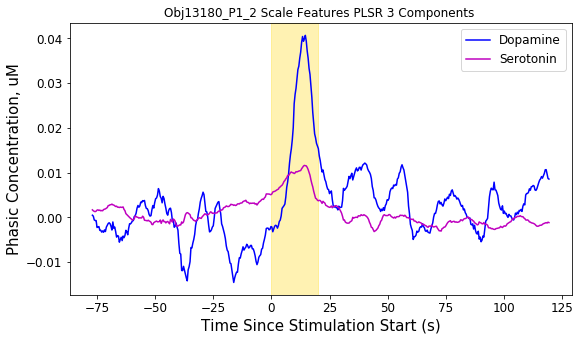

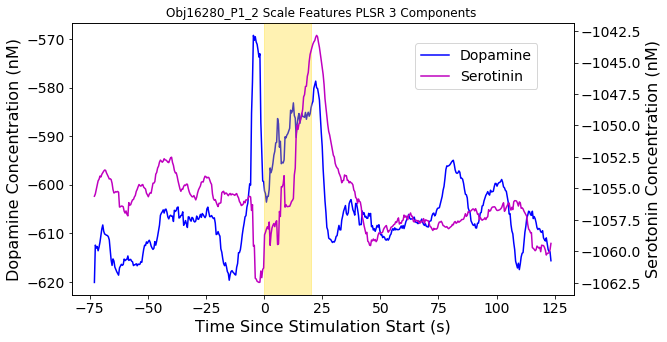

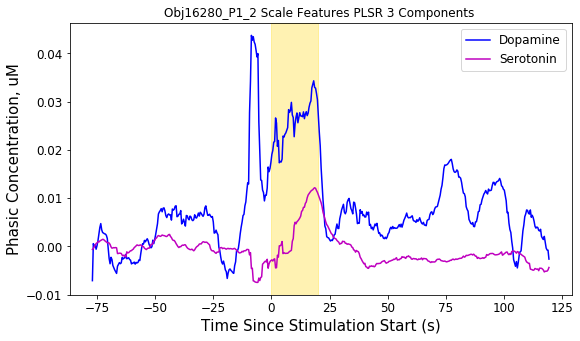

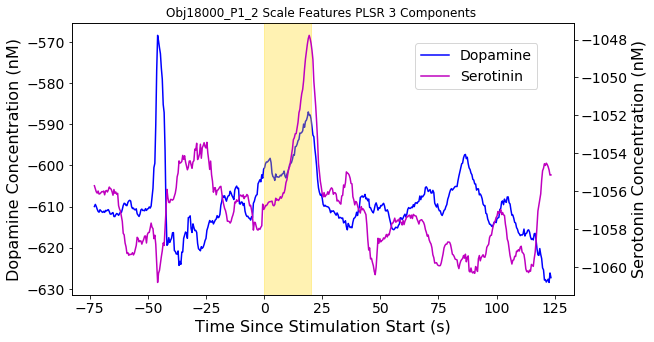

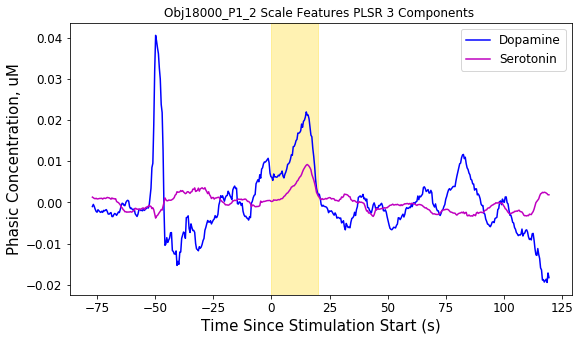

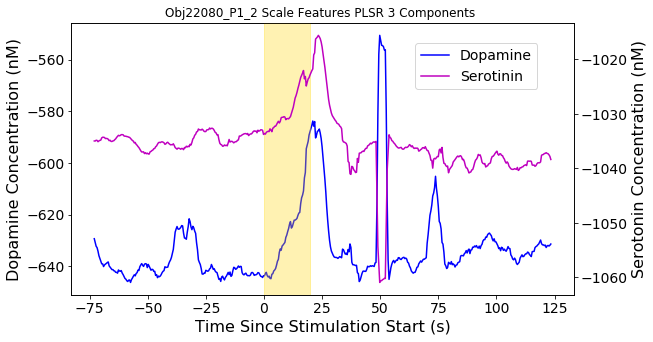

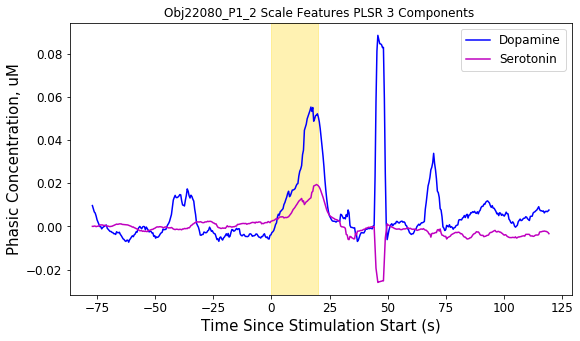

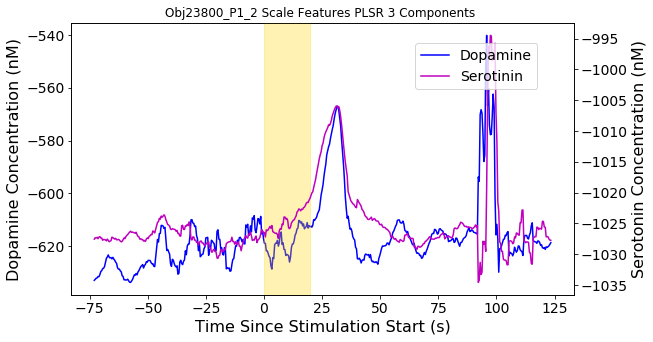

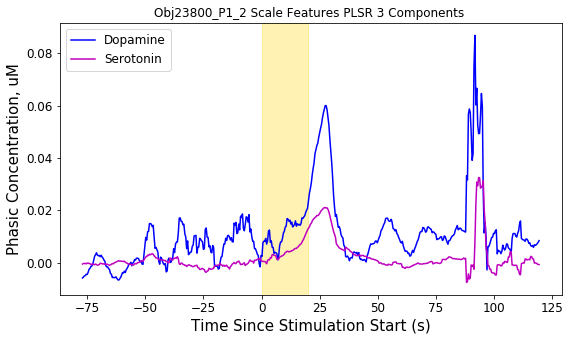

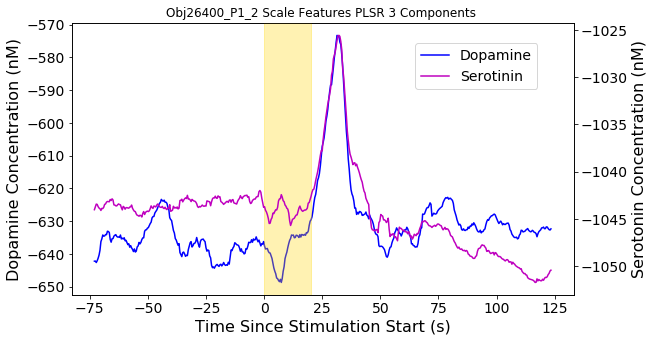

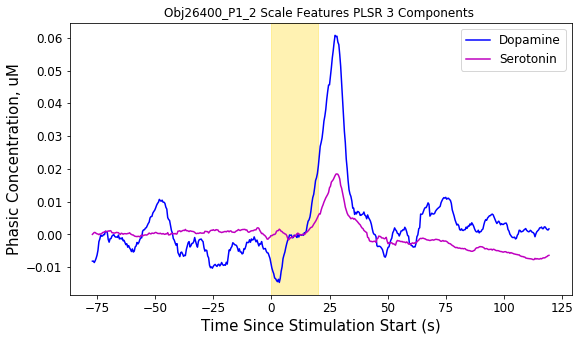

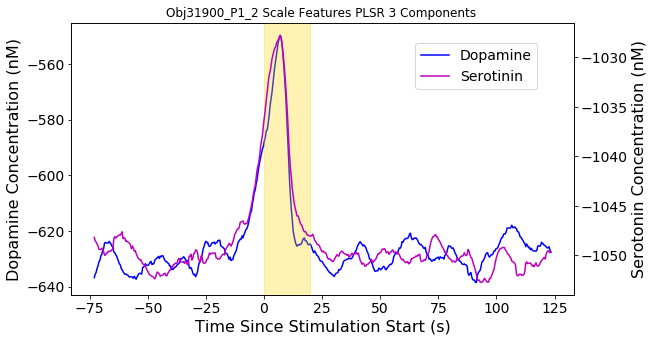

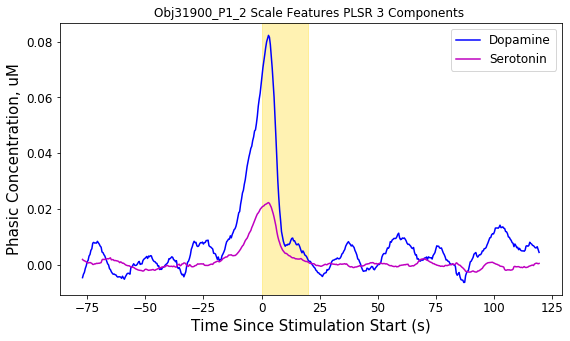

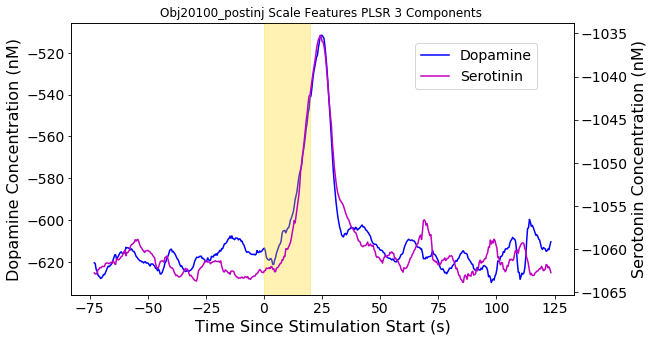

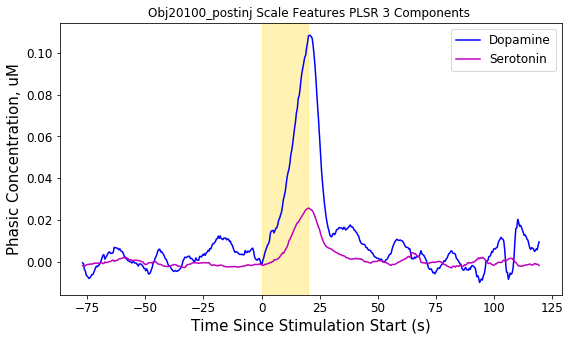

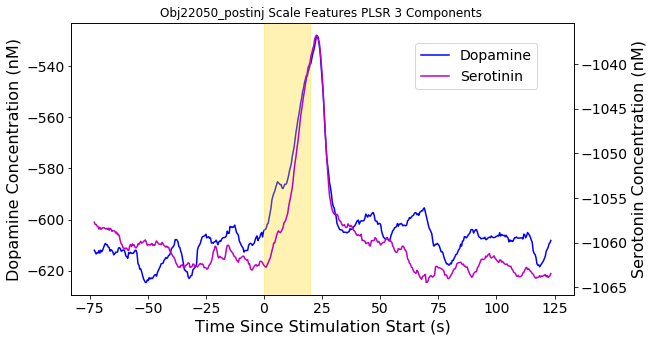

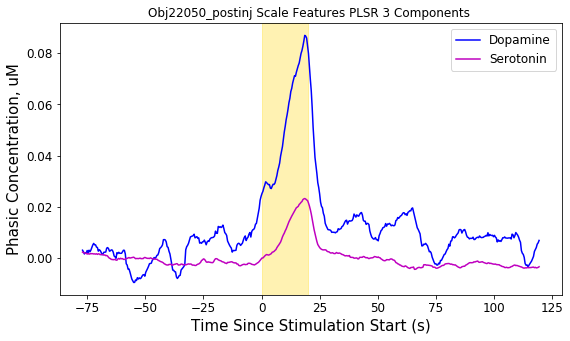

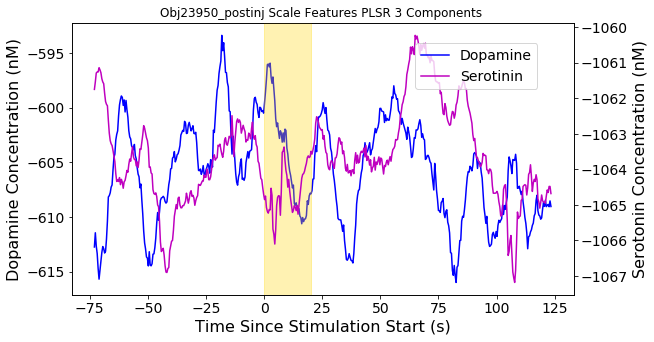

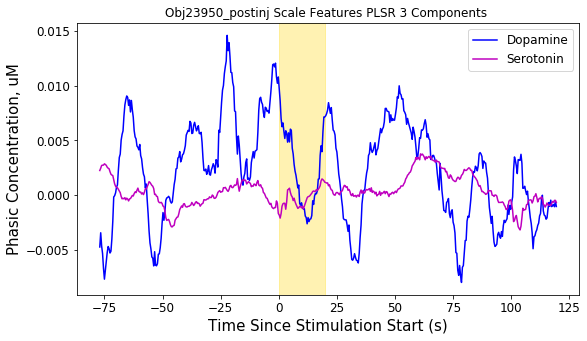

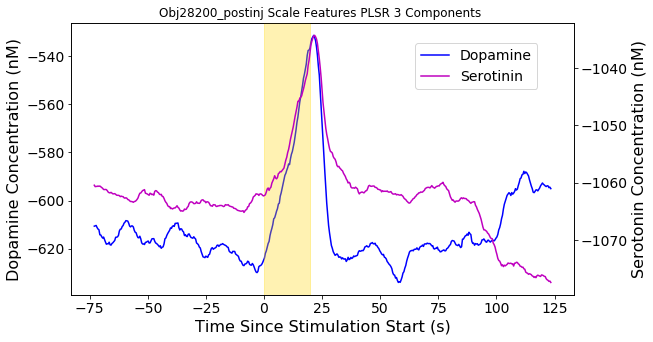

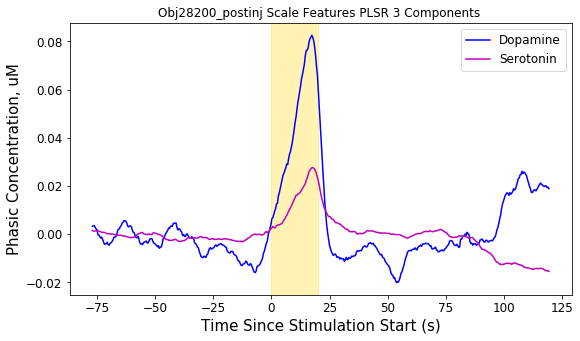

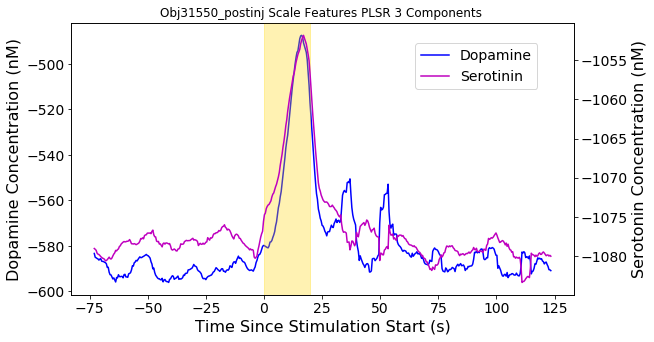

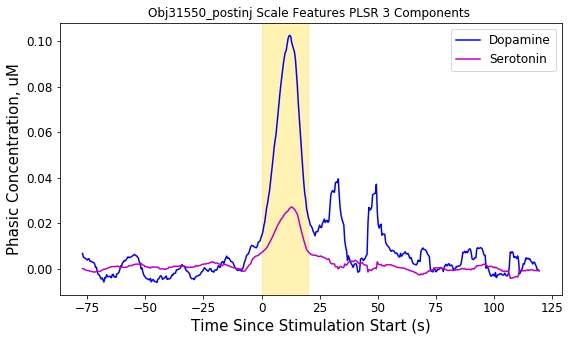

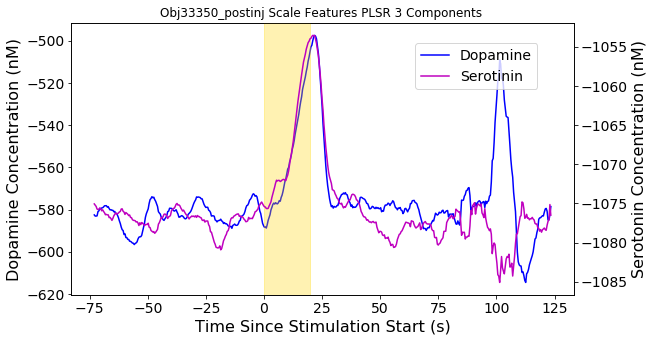

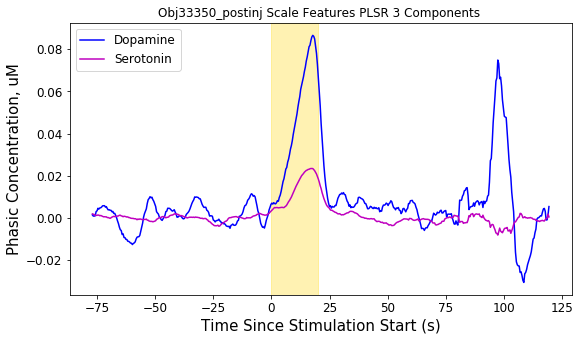

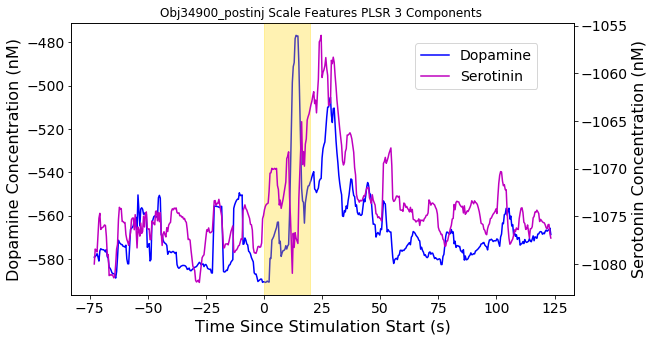

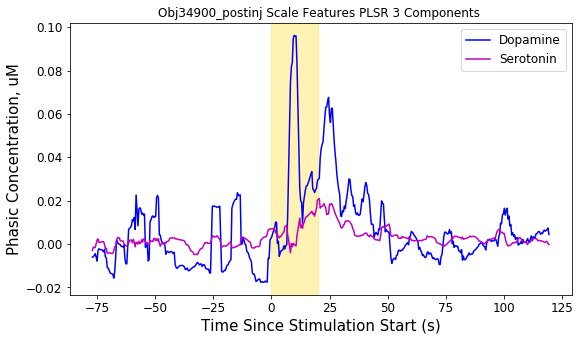

In [49]:
for i in objs:
    fig, ax1 = plt.subplots()
    ax1.plot(time_array+7,1000*moving_average(i._DA_Basal,10),label='Dopamine',color='b')
    ax1.set_xlabel('Time Since Stimulation Start (s)',fontsize=16)
    ax1.tick_params(axis='x',labelsize=14)
    ax1.set_ylabel('Dopamine Concentration (nM)',fontSize=16)
    ax1.tick_params(axis='y',labelsize=14)
    ax2 = ax1.twinx() 
    ax2.plot(time_array+7,1000*moving_average(i._5HT_Basal,10),label='Serotinin',color='m')
    ax2.axvspan(0, 20, color='gold', alpha=0.3)
    #ax2.legend(fontsize=12)
    ax2.set_xlabel('Time Since Stimulation Start (s)',fontsize=16)
    ax2.tick_params(axis='x',labelsize=14)
    ax2.set_ylabel('Serotonin Concentration (nM)',fontSize=16)
    ax2.tick_params(axis='y',labelsize=14)
    fig.legend(loc='upper right', bbox_to_anchor=(0.84, 0.85),fontsize=14)
    plt.title(str(i._SampleName) + ' ' + preProcess + ' ' + modelChoice + ' ' + str(i._NumComp) + ' Components ');
    fig = plt.gcf()
    fig.set_size_inches(9, 5)
    #plt.savefig(i[2:]+'1_3040_combined.jpeg',dpi=600,quality=95)
    plt.show()

    plt.plot(time_array+3,moving_average(i._DA_Phasic,10),label='Dopamine',color='b');
    plt.plot(time_array+3,moving_average(i._5HT_Phasic,10),label='Serotonin',color='m');
    plt.axvspan(0, 20, color='gold', alpha=0.3);
    plt.legend(fontsize=12)
    plt.xlabel('Time Since Stimulation Start (s)',fontsize=15)
    plt.xticks(fontsize=12)
    plt.ylabel('Phasic Concentration, uM',fontSize=15)
    plt.yticks(fontsize=12)
    fig = plt.gcf()
    fig.set_size_inches(9, 5)
    plt.title(str(i._SampleName) + ' ' + preProcess + ' ' + modelChoice + ' ' + str(i._NumComp) + ' Components ');
    plt.show();

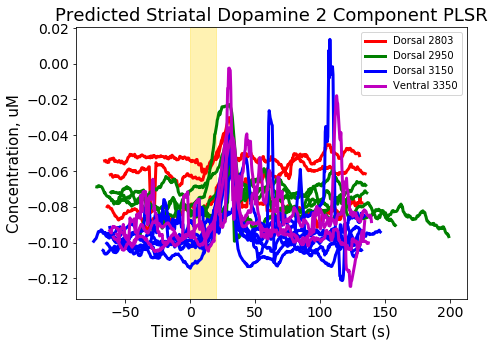

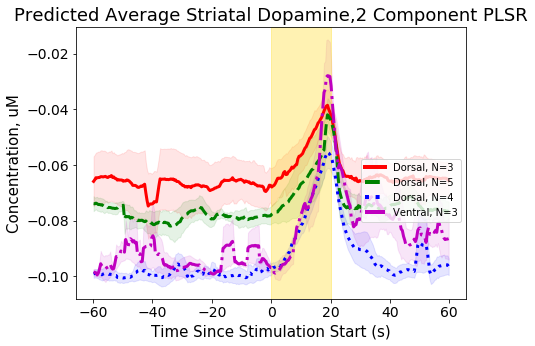

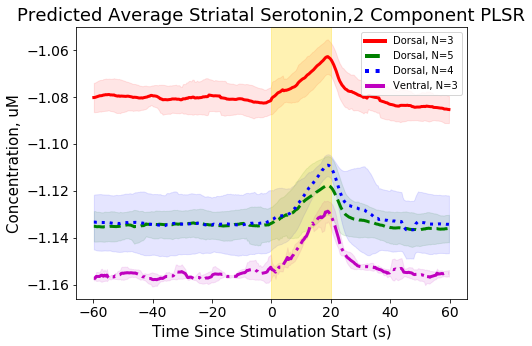

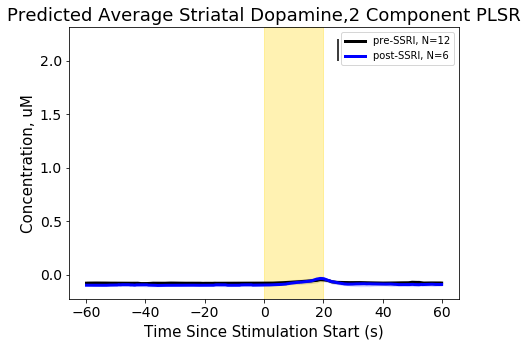

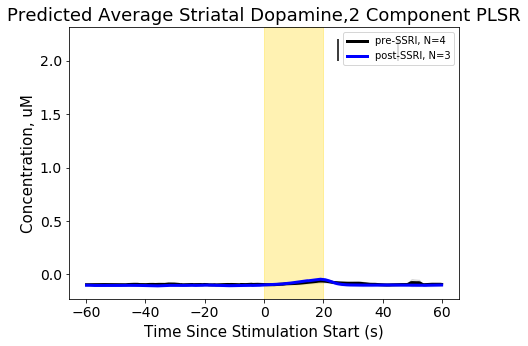

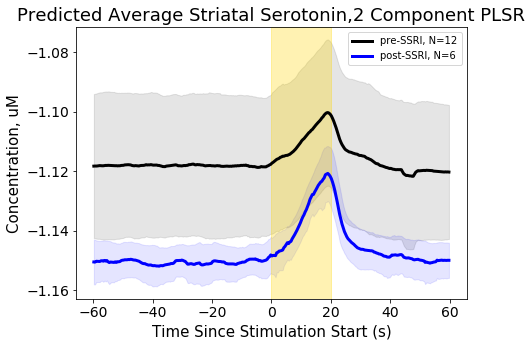

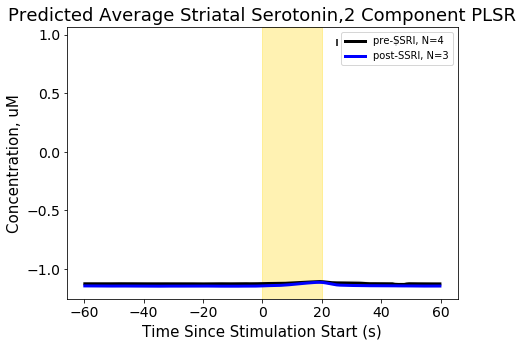

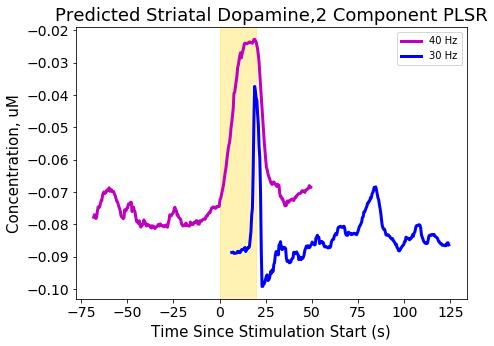

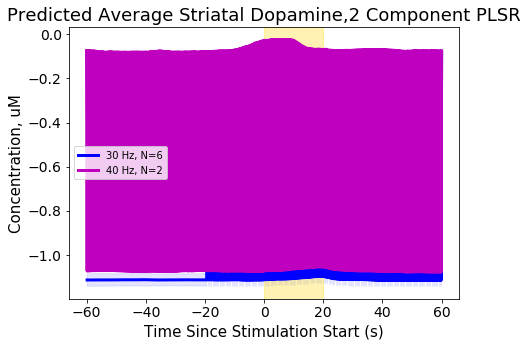

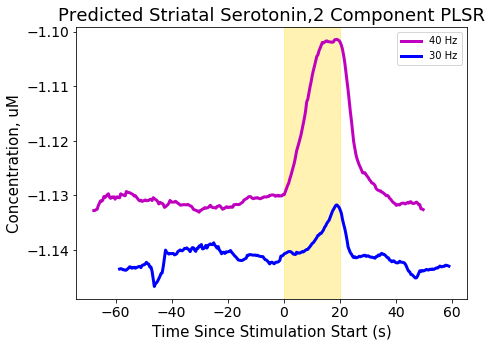

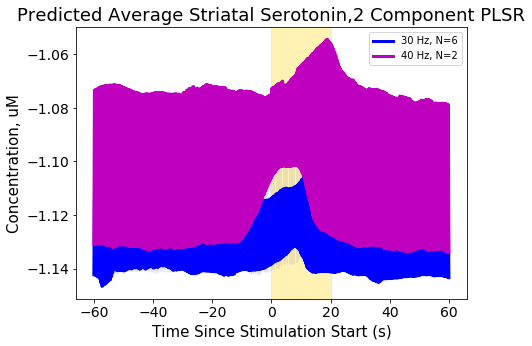

In [50]:
compRange=[2]
posRange=[11803,11950,12150,12350]

for y in compRange:
    color_dict = {'11803':'r','11950':'g','12150':'b','12350':'m','0':'k'}
    marker_dict = {'11803':'solid','11950':'dashed','12150':'dotted','12350':'dashdot'}
    markers_dict = {'11803':'o','11950':'s','12150':'^','12350':'v'}
    hatch_dict = {'11803':'/','11950':'/','12150':'/','12350':'/'}

    for j in stimulationFiles:
        for i in objs:
            if i._StimType != 'None':
                if str(i._SampleName) == 'Obj'+j[1:] and i._NumComp==y:
                    m = max(moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10))
                    time_array_offset=([k for k, l in enumerate(moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10)) if l == m])
                    if int(time_array_offset[0]) >= 300:
                        time_array_offset = 230
                    time_array = np.arange(0,492)
                    time_array = (time_array - time_array_offset+20)*1*400/1000+11
                    MA_Data = moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10)
                    i._AlignedData = pd.DataFrame(MA_Data,time_array)
                    plt.plot((time_array+11),MA_Data,label=str(i._BrainRegion)+' '+str(int(i._Position)-9000),
                             color=color_dict[str(i._Position)],linewidth=3)
    myPlotFormat('Predicted Striatal Dopamine ' + str(y) + ' Component '+ modelChoice,'Time Since Stimulation Start (s)','Concentration, uM')
    plt.show()
    
    for pos in posRange:
        listDF_byPosition=[]
        for i in objs:
            if i._Position == pos:
                if i._NumComp==y:
                    if i._StimType != 'None':
                        listDF_byPosition.append(i._AlignedData)
        Average_byPosition=pd.concat(listDF_byPosition,axis=1)
        #Average_byPosition.to_excel(str(pos)+'All.xlsx')
        numToAvg=len(Average_byPosition.columns)
        Std_byPosition = Average_byPosition.sem(axis=1, level=0)
        Average_byPosition = Average_byPosition.mean(axis=1, level=0)[-60:60]
        plt.fill_between(list(Average_byPosition.index.values),
                         Average_byPosition.loc[-60:60,0]-Std_byPosition.loc[-60:60,0],
                         Average_byPosition.loc[-60:60,0]+Std_byPosition.loc[-60:60,0],
                         color=color_dict[str(pos)],alpha=0.1)
        #print(i._BrainRegion,numToAvg)
        plt.plot(Average_byPosition[-60:60],label=str(i._BrainRegion)+", N="+str(numToAvg),
                 color=color_dict[str(pos)],linewidth=3,linestyle=marker_dict[str(pos)])
    myPlotFormat('Predicted Average Striatal Dopamine,'+str(y)+' Component '+modelChoice,'Time Since Stimulation Start (s)','Concentration, uM')
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='r', lw=4),
                    Line2D([0], [0], color='g', lw=4, linestyle='dashed'),
                    Line2D([0], [0], color='b', lw=4, linestyle='dotted'),
                    Line2D([0], [0], color='m', lw=4,linestyle='dashdot')]
    plt.legend(custom_lines, ['Dorsal, N=3', 'Dorsal, N=5', 'Dorsal, N=4','Ventral, N=3'],loc=7,bbox_to_anchor=(0.5, 0.15, 0.5, 0.5))
    plt.show()

    for j in stimulationFiles:
        for i in objs:
            if i._StimType != 'None':
                if str(i._SampleName) == 'Obj'+j[1:] and i._NumComp==y:
                    m = max(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10))
                    time_array_offset=([k for k, l in enumerate(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)) if l == m])
                    if int(time_array_offset[0]) >= 300:
                        time_array_offset = 230
                    time_array = np.arange(0,492)
                    time_array = (time_array - time_array_offset+20)*1*400/1000+11
                    MA_Data = moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)
                    i._AlignedData = pd.DataFrame(MA_Data,time_array)
                    #plt.plot(time_array+11,MA_Data,label=str(i._BrainRegion)+' '+str(int(i._Position)-9000),
                    #         color=color_dict[str(i._Position)],linewidth=3)
    #myPlotFormat('Predicted Striatal Serotonin ' + str(y) + ' Component '+ modelChoice,'Time Since Stimulation Start (s)','Concentration, uM')
    #plt.show()
    
    for pos in posRange:
        listDF_byPosition=[]
        for i in objs:
            if i._Position == pos:
                if i._NumComp==y:
                    if i._StimType != 'None':
                        listDF_byPosition.append(i._AlignedData)
        Average_byPosition=pd.concat(listDF_byPosition,axis=1)
        #Average_byPosition.to_excel(str(pos)+'All_5HT.xlsx')
        numToAvg=len(Average_byPosition.columns)
        Std_byPosition = Average_byPosition.std(axis=1, level=0)
        Average_byPosition = Average_byPosition.mean(axis=1, level=0)[-60:60]
        plt.fill_between(list(Average_byPosition.index.values),Average_byPosition.loc[-60:60,0]-Std_byPosition.loc[-60:60,0],
                         Average_byPosition.loc[-60:60,0]+Std_byPosition.loc[-60:60,0],color=color_dict[str(pos)],alpha=0.1)
        plt.plot(Average_byPosition[-60:60],label=str(i._BrainRegion)+", N="+str(numToAvg),
                 color=color_dict[str(pos)],linewidth=3,linestyle=marker_dict[str(pos)])
    myPlotFormat('Predicted Average Striatal Serotonin,'+str(y)+' Component '+modelChoice,'Time Since Stimulation Start (s)','Concentration, uM')
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color='r', lw=4),
                    Line2D([0], [0], color='g', lw=4, linestyle='dashed'),
                    Line2D([0], [0], color='b', lw=4, linestyle='dotted'),
                    Line2D([0], [0], color='m', lw=4,linestyle='dashdot')]
    plt.legend(custom_lines, ['Dorsal, N=3', 'Dorsal, N=5', 'Dorsal, N=4','Ventral, N=3'])
    plt.show()
    plt.show()
    
    color_dict = {'pre-SSRI':'k','post-SSRI':'b'}
    drugRange = ['pre-SSRI','post-SSRI']
    for j in stimulationFiles:
        for i in objs:
            if i._StimType != 'None':
                if str(i._SampleName) == 'Obj'+j[1:] and i._NumComp==y:
                    m = max(moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10))
                    time_array_offset=([k for k, l in enumerate(moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10)) if l == m])
                    if int(time_array_offset[0]) >= 300:
                        time_array_offset = 230
                    time_array = np.arange(0,492)
                    time_array = (time_array - time_array_offset+20)*1*400/1000+11
                    MA_Data = moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10)
                    i._AlignedData = pd.DataFrame(MA_Data,time_array)
                    #if i._StimType != 'None' and i._Position >= 12150 and i._Position < 12350:
                        #print(i._SampleName,i._AlignedData.to_string())
                    #plt.plot(time_array+11,MA_Data,label=i._Drug + ' ' + str(i._StimFreq) + ' Hz',
                    #         color=color_dict[str(i._Drug)],linewidth=3)
    #myPlotFormat('Predicted Striatal Dopamine,'+ str(y) +' Component '+modelChoice,'Time Since Stimulation Start (s)','Concentration, uM')
    #plt.show()
    
    for drug in drugRange:
        listDF_byDrug=[]
        for i in objs:
            if i._Drug == drug:
                if i._NumComp==y:
                    if i._StimType != 'None':
                        listDF_byDrug.append(i._AlignedData)
        Average_byDrug=pd.concat(listDF_byDrug,axis=1)
        numToAvg=len(Average_byDrug.columns)
        Std_byDrug = Average_byDrug.std(axis=1, level=0)
        Average_byDrug = Average_byDrug.mean(axis=1, level=0)[-60:60]
        plt.fill_between(list(Average_byDrug.index.values),Average_byDrug.loc[-60:60,0]-Std_byDrug.loc[-60:60,0],
                         Average_byDrug.loc[-60:60,0]+Std_byDrug.loc[-60:60,0],color=color_dict[drug],alpha=0.1)
        plt.plot(Average_byDrug[-60:60],label=drug+', N=' +str(numToAvg),color=color_dict[drug],linewidth=3)
    myPlotFormat('Predicted Average Striatal Dopamine,'+str(y)+' Component '+modelChoice,'Time Since Stimulation Start (s)','Concentration, uM')
    plt.vlines(25,2,2.2)
    plt.show()
    
    for drug in drugRange:
        listDF_byDrug=[]
        for i in objs:
            if i._Drug == drug:
                if i._NumComp==y:
                    if i._StimType != 'None' and i._Position >= 12150 and i._Position < 12350:
                        listDF_byDrug.append(i._AlignedData)
        Average_byDrug=pd.concat(listDF_byDrug,axis=1)
        numToAvg=len(Average_byDrug.columns)
        Std_byDrug = Average_byDrug.std(axis=1, level=0)
        Average_byDrug = Average_byDrug.mean(axis=1, level=0)[-60:60]
        plt.fill_between(list(Average_byDrug.index.values),Average_byDrug.loc[-60:60,0]-Std_byDrug.loc[-60:60,0],
                         Average_byDrug.loc[-60:60,0]+Std_byDrug.loc[-60:60,0],color=color_dict[drug],alpha=0.1)
        plt.plot(Average_byDrug[-60:60],label=drug+', N=' +str(numToAvg),color=color_dict[drug],linewidth=3)
        #print(Average_byDrug.to_string(),drug)
    myPlotFormat('Predicted Average Striatal Dopamine,'+str(y)+' Component '+modelChoice,'Time Since Stimulation Start (s)','Concentration, uM')
    plt.vlines(25,2,2.2)
    plt.vlines(45,2,2.2)
    plt.show()
    
    for j in stimulationFiles:
        for i in objs:
            if i._StimType != 'None':
                if str(i._SampleName) == 'Obj'+j[1:] and i._NumComp==y:
                    m = max(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10))
                    time_array_offset=([k for k, l in enumerate(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)) if l == m])
                    if int(time_array_offset[0]) >= 300:
                        time_array_offset = 230
                    time_array = np.arange(0,492)
                    time_array = (time_array - time_array_offset+20)*1*400/1000+11
                    MA_Data = moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)
                    i._AlignedData = pd.DataFrame(MA_Data,time_array)
                    #if i._StimType != 'None' and i._Position >= 12150 and i._Position < 12350:
                        #print(i._SampleName,i._AlignedData.to_string())
                    #plt.plot(time_array+11,MA_Data,label=i._Drug + ' ' + str(i._StimFreq) + ' Hz',
                    #         color=color_dict[str(i._Drug)],linewidth=3)
    #myPlotFormat('Predicted Striatal Serotonin,'+ str(y) +' Component '+modelChoice,'Time Since Stimulation Start (s)','Concentration, uM')
    #plt.show()
    
    for drug in drugRange:
        listDF_byDrug=[]
        for i in objs:
            if i._Drug == drug:
                if i._NumComp==y:
                    if i._StimType != 'None':
                        listDF_byDrug.append(i._AlignedData)
        Average_byDrug=pd.concat(listDF_byDrug,axis=1)
        numToAvg=len(Average_byDrug.columns)
        Std_byDrug = Average_byDrug.std(axis=1, level=0)
        Average_byDrug = Average_byDrug.mean(axis=1, level=0)[-60:60]
        plt.fill_between(list(Average_byDrug.index.values),Average_byDrug.loc[-60:60,0]-Std_byDrug.loc[-60:60,0],
                         Average_byDrug.loc[-60:60,0]+Std_byDrug.loc[-60:60,0],color=color_dict[drug],alpha=0.1)
        plt.plot(Average_byDrug[-60:60],label=drug+ ", N="+str(numToAvg),color=color_dict[drug],linewidth=3)
    myPlotFormat('Predicted Average Striatal Serotonin,'+str(y)+' Component '+modelChoice,'Time Since Stimulation Start (s)','Concentration, uM')
    plt.show()
    
    for drug in drugRange:
        listDF_byDrug=[]
        for i in objs:
            if i._Drug == drug:
                if i._NumComp==y:
                    if i._StimType != 'None' and i._Position >= 12150 and i._Position < 12350:
                        listDF_byDrug.append(i._AlignedData)
        Average_byDrug=pd.concat(listDF_byDrug,axis=1)
        numToAvg=len(Average_byDrug.columns)
        Std_byDrug = Average_byDrug.std(axis=1, level=0)
        Average_byDrug = Average_byDrug.mean(axis=1, level=0)[-60:60]
        plt.fill_between(list(Average_byDrug.index.values),Average_byDrug.loc[-60:60,0]-Std_byDrug.loc[-60:60,0],
                         Average_byDrug.loc[-60:60,0]+Std_byDrug.loc[-60:60,0],color=color_dict[drug],alpha=0.1)
        plt.plot(Average_byDrug[-60:60],label=drug+ ", N="+str(numToAvg),color=color_dict[drug],linewidth=3)
        #print(Average_byDrug.to_string(),drug)
    myPlotFormat('Predicted Average Striatal Serotonin,'+str(y)+' Component '+modelChoice,'Time Since Stimulation Start (s)','Concentration, uM')
    plt.vlines(25,.90,.96)
    plt.vlines(45,.90,.96)
    plt.show()
    
    color_dict = {20:'k',30:'b',40:'m'}
    freqRange = [30,40]
    freqList = ['\\11250_P1_2','\\18000_P1_2']
    for j in freqList:
        for i in objs:
            if i._StimType != 'None'and (i._Position == 11950 or i._Position == 11803):
                if str(i._SampleName) == 'Obj'+j[1:] and i._NumComp==y:
                    m = max(moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10))
                    time_array_offset=([k for k, l in enumerate(moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10)) if l == m])
                    if int(time_array_offset[0]) >= 300:
                        time_array_offset = 230
                    time_array = np.arange(0,492)
                    time_array = (time_array - time_array_offset+20)*1*400/1000
                    MA_Data = moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10)
                    i._AlignedData = pd.DataFrame(MA_Data,time_array)
                    df=pd.DataFrame(MA_Data,time_array)
                    df.to_excel(str(i._StimFreq)+'_DA.xlsx')
                    plt.plot(time_array[37:332]+11,MA_Data[37:332],label=str(i._StimFreq) + ' Hz',
                             color=color_dict[i._StimFreq],linewidth=3)
    myPlotFormat('Predicted Striatal Dopamine,'+ str(y) +' Component '+modelChoice,'Time Since Stimulation Start (s)','Concentration, uM')
    plt.show()
    
    for freq in freqRange:
        listDF_byFreq=[]
        for i in objs:
            if i._StimFreq == freq:
                if i._NumComp==y:
                    if i._StimType != 'None' and (i._Position == 11950 or i._Position == 11803):
                        listDF_byFreq.append(i._AlignedData)
        Average_byFreq=pd.concat(listDF_byFreq,axis=1)
        numToAvg=len(Average_byFreq.columns)
        Std_byFreq = Average_byFreq.std(axis=1, level=0)
        Average_byFreq = Average_byFreq.mean(axis=1, level=0)[-60:60]
        plt.fill_between(list(Average_byFreq.index.values),Average_byFreq.loc[-60:60,0]-Std_byFreq.loc[-60:60,0],
                         Average_byFreq.loc[-60:60,0]+Std_byFreq.loc[-60:60,0],color=color_dict[freq],alpha=0.1)
        plt.plot(Average_byFreq[-60:60],label=str(freq)+' Hz, N=' +str(numToAvg),color=color_dict[freq],linewidth=3)
    myPlotFormat('Predicted Average Striatal Dopamine,'+str(y)+' Component '+modelChoice,'Time Since Stimulation Start (s)','Concentration, uM')
    plt.show()
    
    freqList = ['\\11250_P1_2','\\18000_P1_2']
    for j in freqList:
        for i in objs:
            if i._StimType != 'None' and (i._Position == 11950 or i._Position == 11803):
                if str(i._SampleName) == 'Obj'+j[1:] and i._NumComp==y:
                    m = max(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10))
                    time_array_offset=([k for k, l in enumerate(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)) if l == m])
                    if int(time_array_offset[0]) >= 300:
                        time_array_offset = 230
                    time_array = np.arange(0,492)
                    time_array = (time_array - time_array_offset+20)*1*400/1000
                    MA_Data = moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)
                    df=pd.DataFrame(MA_Data,time_array)
                    df.to_excel(str(i._StimFreq)+'_HT.xlsx')
                    i._AlignedData = pd.DataFrame(MA_Data,time_array)
                    plt.plot(time_array[37:332]+11,MA_Data[37:332],label=str(i._StimFreq) + ' Hz',
                             color=color_dict[i._StimFreq],linewidth=3)
    myPlotFormat('Predicted Striatal Serotonin,'+ str(y) +' Component '+modelChoice,'Time Since Stimulation Start (s)','Concentration, uM')
    plt.show()
    
    for freq in freqRange:
        listDF_byFreq=[]
        for i in objs:
            if i._StimFreq == freq:
                if i._NumComp==y:
                    if i._StimType != 'None'and (i._Position == 11950 or i._Position == 11803):
                        listDF_byFreq.append(i._AlignedData)
        Average_byFreq=pd.concat(listDF_byFreq,axis=1)
        numToAvg=len(Average_byFreq.columns)
        Std_byFreq = Average_byFreq.std(axis=1, level=0)
        Average_byFreq = Average_byFreq.mean(axis=1, level=0)[-60:60]
        plt.fill_between(list(Average_byFreq.index.values),Average_byFreq.loc[-60:60,0]-Std_byFreq.loc[-60:60,0],
                         Average_byFreq.loc[-60:60,0]+Std_byFreq.loc[-60:60,0],color=color_dict[freq],alpha=0.1)
        plt.plot(Average_byFreq[-60:60],label=str(freq)+ " Hz, N="+str(numToAvg),color=color_dict[freq],linewidth=3)
    myPlotFormat('Predicted Average Striatal Serotonin,'+str(y)+' Component '+modelChoice,'Time Since Stimulation Start (s)','Concentration, uM')
    plt.show()

0.01503999999999972 pre-SSRI 30 Pulse 11803
0.0177499999999986 pre-SSRI 30 Pulse 11803
0.01762999999999426 pre-SSRI 40 Pulse 11803
0.018679999999991814 pre-SSRI 30 Pulse 11950
0.02860000000000462 pre-SSRI 40 Pulse 11950
0.013709999999987676 pre-SSRI 30 Pulse 11950
0.012950000000002904 pre-SSRI 30 Pulse 11950
0.010249999999994763 pre-SSRI 30 Pulse 11950
0.023020000000000707 pre-SSRI 30 Pulse 12150


TypeError: 'int' object is not subscriptable

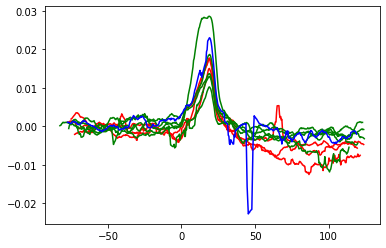

In [51]:
color_dict = {'11803':'r','11950':'g','12150':'b','12350':'m'}

listofDFs_PhasicHT1=[]
for y in compRange:
    for j in stimulationFiles:
        for i in objs:
            if i._StimType != 'None':
                if str(i._SampleName) == 'Obj'+j[1:] and i._NumComp==y:
                    m = max(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10))
                    time_array_offset=([k for k, l in enumerate(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)) if l == m])
                    if int(time_array_offset[0]) >= 300:
                        time_array_offset = 230
                    time_array = np.arange(0,492)
                    time_array = (time_array - time_array_offset[0]+20)*1*400/1000+11
                    listofDFs_PhasicHT1.append(pd.DataFrame((moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)-np.round(np.mean((i._Data['Predicted 5HT (uM)'].iloc[:101]).to_numpy()),3)),time_array))
                    plt.plot(time_array,(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)-np.round(np.mean((i._Data['Predicted 5HT (uM)'].iloc[:101]).to_numpy()),3)),label=i._BrainRegion+' '+str(i._Position-9000),color=color_dict[str(i._Position)])
                    print(np.amax((moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)-np.round(np.mean((i._Data['Predicted 5HT (uM)'].iloc[:101]).to_numpy()),3))),i._Drug,i._StimFreq,i._StimType,i._Position)
    myPlotFormat('Predicted Striatal Phasic Serotonin '  + str(y) + ' Component '+modelChoice,'Time Since Stimulation Start (s)','Phasic Concentration, uM')
    plt.show()

    listofDFs_PhasicDA1=[]
    for j in stimulationFiles:
        for i in objs:
            if i._StimType != 'None':
                if str(i._SampleName) == 'Obj'+j[1:] and i._NumComp==y:
                    m = max(moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10))
                    time_array_offset=([k for k, l in enumerate(moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10)) if l == m])
                    if int(time_array_offset[0]) >= 300:
                        time_array_offset = 230
                    time_array = np.arange(0,492)
                    time_array = (time_array - time_array_offset+20)*1*400/1000+11
                    listofDFs_PhasicDA1.append(pd.DataFrame((moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10)-np.round(np.mean((i._Data['Predicted DA (uM)'].iloc[:101]).to_numpy()),3)),time_array))
                    plt.plot(time_array,(moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10)-np.round(np.mean((i._Data['Predicted DA (uM)'].iloc[:101]).to_numpy()),3)),label=i._BrainRegion+' '+str(i._Position-9000),color=color_dict[str(i._Position)])
                    print(np.amax((moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10)-np.round(np.mean((i._Data['Predicted DA (uM)'].iloc[:101]).to_numpy()),3))),i._Drug,i._StimFreq,i._StimType,i._Position)
    myPlotFormat('Predicted Striatal Phasic Dopamine ' + str(y) +' Component '+modelChoice,'Time Since Stimulation Start (s)','Phasic Concentration, uM')
    plt.show()

color_dict = {'pre-SSRI':'r','post-SSRI':'g'}
listofDFs_PhasicHT2=[]
for y in compRange:
    for j in stimulationFiles:
        for i in objs:
            if i._StimType != 'None':
                if str(i._SampleName) == 'Obj'+j[1:] and i._NumComp==y:
                    m = max(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10))
                    time_array_offset=([k for k, l in enumerate(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)) if l == m])
                    if int(time_array_offset[0]) >= 300:
                        time_array_offset = 230
                    time_array = np.arange(0,492)
                    time_array = (time_array - time_array_offset[0]+20)*1*400/1000+11
                    listofDFs_PhasicHT2.append(pd.DataFrame((moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)-np.round(np.mean((i._Data['Predicted 5HT (uM)'].iloc[:101]).to_numpy()),3)),time_array))
                    plt.plot(time_array,(moving_average(i._Data['Predicted 5HT (uM)'].to_numpy(),10)-np.round(np.mean((i._Data['Predicted 5HT (uM)'].iloc[:101]).to_numpy()),3)),label=i._Drug + str(i._StimFreq),color=color_dict[str(i._Drug)])
    myPlotFormat('Predicted Striatal Phasic Serotonin '  + str(y) +' Component '+modelChoice,'Time Since Stimulation Start (s)','Phasic Concentration, uM')
    plt.show()

    listofDFs_PhasicDA2=[]
    for j in stimulationFiles:
        for i in objs:
            if i._StimType != 'None':
                if str(i._SampleName) == 'Obj'+j[1:] and i._NumComp==y:
                    m = max(moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10))
                    time_array_offset=([k for k, l in enumerate(moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10)) if l == m])
                    if int(time_array_offset[0]) >= 300:
                        time_array_offset = 230
                    time_array = np.arange(0,492)
                    time_array = (time_array - time_array_offset+20)*1*400/1000+11
                    listofDFs_PhasicDA2.append(pd.DataFrame((moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10)-np.round(np.mean((i._Data['Predicted DA (uM)'].iloc[:101]).to_numpy()),3)),time_array))
                    plt.plot(time_array,(moving_average(i._Data['Predicted DA (uM)'].to_numpy(),10)-np.round(np.mean((i._Data['Predicted DA (uM)'].iloc[:101]).to_numpy()),3)),label=i._Drug + str(i._StimFreq),color=color_dict[str(i._Drug)])
    myPlotFormat('Predicted Striatal Phasic Dopamine '  + str(y) + ' Component '+modelChoice,'Time Since Stimulation Start (s)','Phasic Concentration, uM')
    plt.show()

In [ ]:
#SSRI 

In [ ]:
df_PhasicHT1=pd.concat(listofDFs_PhasicHT1,axis=1)
df_PhasicHT1_Std=df_PhasicHT1.std(axis=1, level=0)
df_PhasicHT1_only_preSSRI=df_PhasicHT1.iloc[:,8:12]
df_PhasicHT1_only_preSSRI_Std=df_PhasicHT1_only_preSSRI.std(axis=1, level=0)
df_PhasicHT1_only_postSSRI=df_PhasicHT1.iloc[:,12:15]
df_PhasicHT1_only_postSSRI_Std=df_PhasicHT1_only_postSSRI.std(axis=1, level=0)

df_PhasicDA1=pd.concat(listofDFs_PhasicDA1,axis=1)
df_PhasicDA1_Std=df_PhasicDA1.std(axis=1, level=0)
df_PhasicDA1_only_preSSRI=df_PhasicDA1.iloc[:,8:12]
df_PhasicDA1_only_preSSRI_Std=df_PhasicDA1_only_preSSRI.std(axis=1, level=0)
df_PhasicDA1_only_postSSRI=df_PhasicDA1.iloc[:,12:15]
df_PhasicDA1_only_postSSRI_Std=df_PhasicDA1_only_postSSRI.std(axis=1, level=0)

plt.plot(df_PhasicHT1.mean(axis=1, level=0),label='HT (N=7)')
plt.fill_between(np.linspace(-97.2+11,124.4+11,554), (df_PhasicHT1.mean(axis=1, level=0)-df_PhasicHT1_Std)[0],(df_PhasicHT1.mean(axis=1, level=0)+df_PhasicHT1_Std)[0],color='b',alpha=0.1)
plt.plot(df_PhasicDA1.mean(axis=1, level=0),label='DA (N=7)')
plt.fill_between(np.linspace(-97.2+11,124.4+11,554), (df_PhasicDA1.mean(axis=1, level=0)-df_PhasicDA1_Std)[0],(df_PhasicDA1.mean(axis=1, level=0)+df_PhasicDA1_Std)[0],color='r',alpha=0.1)
myPlotFormat('Average All Phasic Release, Pos 3150 '+modelChoice,'Time Since Stimulation Start (s)','Phasic Concentration, uM')
plt.show()

plt.plot(df_PhasicHT1_only_preSSRI.mean(axis=1, level=0),label='preSSRI (N=4)')
plt.fill_between(np.linspace(-97.2+11,124.4+11,554), (df_PhasicHT1_only_preSSRI.mean(axis=1, level=0)-df_PhasicHT1_only_preSSRI_Std)[0],(df_PhasicHT1_only_preSSRI.mean(axis=1, level=0)+df_PhasicHT1_only_preSSRI_Std)[0],color='b',alpha=0.1)
plt.plot(df_PhasicHT1_only_postSSRI.mean(axis=1, level=0),label='postSSRI (N=3)')
plt.fill_between(np.linspace(-97.2+11,124.4+11,554), (df_PhasicHT1_only_postSSRI.mean(axis=1, level=0)-df_PhasicHT1_only_postSSRI_Std)[0],(df_PhasicHT1_only_postSSRI.mean(axis=1, level=0)+df_PhasicHT1_only_postSSRI_Std)[0],color='r',alpha=0.1)
myPlotFormat('Average 5HT Phasic Release, Pos 3150 '+modelChoice,'Time Since Stimulation Start (s)','Phasic Concentration, uM')
plt.show()

plt.plot(df_PhasicDA1_only_preSSRI.mean(axis=1, level=0),label='preSSRI (N=4)')
plt.fill_between(np.linspace(-97.2+11,124.4+11,554), (df_PhasicDA1_only_preSSRI.mean(axis=1, level=0)-df_PhasicDA1_only_preSSRI_Std)[0],(df_PhasicDA1_only_preSSRI.mean(axis=1, level=0)+df_PhasicDA1_only_preSSRI_Std)[0],color='b',alpha=0.1)
plt.plot(df_PhasicDA1_only_postSSRI.mean(axis=1, level=0),label='postSSRI (N=3)')
plt.fill_between(np.linspace(-97.2+11,124.4+11,554), (df_PhasicDA1_only_postSSRI.mean(axis=1, level=0)-df_PhasicDA1_only_postSSRI_Std)[0],(df_PhasicDA1_only_postSSRI.mean(axis=1, level=0)+df_PhasicDA1_only_postSSRI_Std)[0],color='r',alpha=0.1)
myPlotFormat('Average DA Phasic Release, Pos 3150 '+modelChoice,'Time Since Stimulation Start (s)','Phasic Concentration, uM')
plt.show()


In [ ]:
df_PhasicHT1=pd.concat(listofDFs_PhasicHT1,axis=1)
df_PhasicHT1_Std=df_PhasicHT1.std(axis=1, level=0)
df_PhasicHT1_only_preSSRI=df_PhasicHT1.iloc[:,:12]
df_PhasicHT1_only_preSSRI_Std=df_PhasicHT1_only_preSSRI.std(axis=1, level=0)
df_PhasicHT1_only_postSSRI=df_PhasicHT1.iloc[:,12:]
df_PhasicHT1_only_postSSRI_Std=df_PhasicHT1_only_postSSRI.std(axis=1, level=0)

df_PhasicDA1=pd.concat(listofDFs_PhasicDA1,axis=1)
df_PhasicDA1_Std=df_PhasicDA1.std(axis=1, level=0)
df_PhasicDA1_only_preSSRI=df_PhasicDA1.iloc[:,:12]
df_PhasicDA1_only_preSSRI_Std=df_PhasicDA1_only_preSSRI.std(axis=1, level=0)
df_PhasicDA1_only_postSSRI=df_PhasicDA1.iloc[:,12:]
df_PhasicDA1_only_postSSRI_Std=df_PhasicDA1_only_postSSRI.std(axis=1, level=0)

plt.plot(df_PhasicHT1.mean(axis=1, level=0),label='HT (N=18)')
plt.fill_between(np.linspace(-97.2+11,124.4+11,554), (df_PhasicHT1.mean(axis=1, level=0)-df_PhasicHT1_Std)[0],(df_PhasicHT1.mean(axis=1, level=0)+df_PhasicHT1_Std)[0],color='b',alpha=0.1)
plt.plot(df_PhasicDA1.mean(axis=1, level=0),label='DA (N=18)')
plt.fill_between(np.linspace(-97.2+11,124.4+11,554), (df_PhasicDA1.mean(axis=1, level=0)-df_PhasicDA1_Std)[0],(df_PhasicDA1.mean(axis=1, level=0)+df_PhasicDA1_Std)[0],color='r',alpha=0.1)
myPlotFormat('Average All Phasic Release, All Pos '+modelChoice,'Time Since Stimulation Start (s)','Phasic Concentration, uM')
plt.show()

plt.plot(df_PhasicHT1_only_preSSRI.mean(axis=1, level=0),label='preSSRI (N=12)')
plt.fill_between(np.linspace(-97.2+11,124.4+11,554), (df_PhasicHT1_only_preSSRI.mean(axis=1, level=0)-df_PhasicHT1_only_preSSRI_Std)[0],(df_PhasicHT1_only_preSSRI.mean(axis=1, level=0)+df_PhasicHT1_only_preSSRI_Std)[0],color='b',alpha=0.1)
plt.plot(df_PhasicHT1_only_postSSRI.mean(axis=1, level=0),label='postSSRI (N=6)')
plt.fill_between(np.linspace(-97.2+11,124.4+11,554), (df_PhasicHT1_only_postSSRI.mean(axis=1, level=0)-df_PhasicHT1_only_postSSRI_Std)[0],(df_PhasicHT1_only_postSSRI.mean(axis=1, level=0)+df_PhasicHT1_only_postSSRI_Std)[0],color='r',alpha=0.1)
myPlotFormat('Average 5HT Phasic Release, All Pos'+modelChoice,'Time Since Stimulation Start (s)','Phasic Concentration, uM')
plt.show()

plt.plot(df_PhasicDA1_only_preSSRI.mean(axis=1, level=0),label='preSSRI (N=12)')
plt.fill_between(np.linspace(-97.2+11,124.4+11,554), (df_PhasicDA1_only_preSSRI.mean(axis=1, level=0)-df_PhasicDA1_only_preSSRI_Std)[0],(df_PhasicDA1_only_preSSRI.mean(axis=1, level=0)+df_PhasicDA1_only_preSSRI_Std)[0],color='b',alpha=0.1)
plt.plot(df_PhasicDA1_only_postSSRI.mean(axis=1, level=0),label='postSSRI (N=6)')
plt.fill_between(np.linspace(-97.2+11,124.4+11,554), (df_PhasicDA1_only_postSSRI.mean(axis=1, level=0)-df_PhasicDA1_only_postSSRI_Std)[0],(df_PhasicDA1_only_postSSRI.mean(axis=1, level=0)+df_PhasicDA1_only_postSSRI_Std)[0],color='r',alpha=0.1)
myPlotFormat('Average DA Phasic Release, All Pos '+modelChoice,'Time Since Stimulation Start (s)','Phasic Concentration, uM')
plt.show()


In [ ]:
#release/reuptake
for j in stimulationFiles:
    for i in objs:
        #find peak max, fit linear model from 20->80% on both sides
    